# Telemetry Data for CI Clusters

Every cluster running an OpenShift CI job sends some operational data back to Red Hat via [Telemetry](https://docs.openshift.com/container-platform/4.7/support/remote_health_monitoring/about-remote-health-monitoring.html#telemetry-about-telemetry_about-remote-health-monitoring). This data gets stored as [Prometheus](https://prometheus.io/docs/introduction/overview/) metrics in a [Thanos](https://github.com/thanos-io/thanos) deployment at Red Hat. Some examples of the prometheus metrics collected here include CPU and memory capacity, operators installed, alerts fired, provider platform, etc. Thus, in addition to high level test run data on testgrid and prow, we also have detailed time series data available for the CI clusters that ran the tests.

In this notebook, we will show how to access this telemetry data using some open source tools developed by the AIOps team. Specifically we will show that, given a specific CI job run, how to get the telemetry data associated with the cluster that ran it.

**NOTE:** Since this data is currently hosted on a Red Hat internal Thanos, only those users with access to it will be able to run this notebook to get "live" data. To ensure that the wider open source community is also able to use this data for further analysis, we will use this notebook to extract a snippet of this data and save it on our public GitHub repo.

In [1]:
# import all the required libraries
import warnings
import datetime as dt
from IPython.display import display
from urllib3.exceptions import InsecureRequestWarning

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from prometheus_api_client import PrometheusConnect, MetricSnapshotDataFrame

In [2]:
# config for a pretty notebook
sns.set()
warnings.filterwarnings("ignore", category=InsecureRequestWarning)

## Data Access Setup

In this section, we will configure the [prometheus-api-client-python](https://github.com/AICoE/prometheus-api-client-python) tool to pull data from our Thanos instance. That is, set the value of `PROM_URL` to the Thanos endpoint, and set the value of `PROM_ACCESS_TOKEN` to the bearer token for authentication.

We will also set the timestamp from which telemetry data is to be pulled.

In [3]:
# prometheus from which metrics are to be fetched
PROM_URL = "https://telemeter-lts.datahub.redhat.com/"
PROM_ACCESS_TOKEN = "insert_token_here"

In [4]:
# prometheus connector object
pc = PrometheusConnect(
    url=PROM_URL,
    disable_ssl=True,
    headers={"Authorization": f"bearer {PROM_ACCESS_TOKEN}"},
)

In [5]:
# timestamp for which prometheus queries will be evaluated
query_eval_ts = dt.datetime(
    year=2021,
    month=3,
    day=30,
    hour=12,
    tzinfo=dt.timezone.utc,
).timestamp()

In [6]:
# which metrics to fetch
# we will try to get all metrics, but leave out ones that may have potentially sensitive data
metrics_to_fetch = [
    m for m in pc.all_metrics() if "subscription" not in m and "internal" not in m
]

In [12]:
# these fields are either irrelevant or contain something that could potentially be sensitive
# either way, these likely wont be useful for analysis anyway so exclude them when reading data
drop_cols = [
    "prometheus",
    "tenant_id",
    "endpoint",
    "instance",
    "receive",
    "url",
]

## Get All Data for a Given Job Build

In this section, we will get all the prometheus metrics corresponding to a given job name and build id. The job name and build id can be obtained either directly from the testgrid UI, or from the `query` and `changelists` fields respectively in the testgrid json as shown in the [testgrid metadata EDA notebook](../TestGrid/testgrid_metadata_EDA.ipynb).

One of the metrics stored in Thanos is `cluster_installer`. This metric describes what entity triggered the install of each cluster. For the clusters that run OpenShift CI jobs, the `invoker` label value in this metric is set to `openshift-internal-ci/{job_name}/{build_id}`.

Therefore, we can get all data for a given job build by first finding the ID of the cluster that ran it (using `cluster_installer`), and then querying prometheus for metrics where the `_id` label value equals this cluster ID. These steps are demonstrated through the example below.

In [9]:
# example job and build
job_name = "periodic-ci-openshift-release-master-ci-4.7-upgrade-from-stable-4.6-e2e-azure-upgrade"
build_id = "1376841869236899840"

In [10]:
# get installer info for the job/build
job_build_cluster_installer = pc.custom_query(
    query=f'cluster_installer{{invoker="openshift-internal-ci/{job_name}/{build_id}"}}',
    params={"time": query_eval_ts},
)

# extract cluster id out of the installer info metric
cluster_id = job_build_cluster_installer[0]["metric"]["_id"]

### Get One Metric

Before we fetch all the metrics, let's fetch just one metric and familiarize ourselves with the data format, and understand how to interpret it. In the cell below, we will look at an example metric, `cluster:cpu_capacity:sum`.

In [11]:
# fetch the metric and format it into a df
metric_df = MetricSnapshotDataFrame(
    pc.custom_query(
        query=f'cluster:capacity_cpu_cores:sum{{_id="{cluster_id}"}}',
        params={"time": query_eval_ts},
    )
)

# drop irrelavant data
metric_df.drop(columns=drop_cols, errors="ignore", inplace=True)

metric_df

,__name__,_id,label_beta_kubernetes_io_instance_type,label_kubernetes_io_arch,label_node_openshift_io_os_id,timestamp,value,label_node_role_kubernetes_io
0,cluster:capacity_cpu_cores:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D4s_v3,amd64,rhcos,1617105600,12,NaN
1,cluster:capacity_cpu_cores:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D8s_v3,amd64,rhcos,1617105600,24,master


**HOW TO READ THIS DATAFRAME**

In the above dataframe, each column represents a "label" of the prometheus metric, and each row represents a different "label configuration". In this example, the first row has `label_node_role_kubernetes_io` = `NaN` and `value` = `12`, and the second row has `label_node_role_kubernetes_io` = `master` and `value` = `24`. This means that in this cluster, the `master` node had 24 CPU cores, and the `worker` node had 12 CPU cores.

To learn more about labels, label configurations, and the prometheus data model in general, please check out their official documentation [here](https://prometheus.io/docs/concepts/data_model/).

### Get All Metrics

Now that we understand the data structure of the metrics, let's fetch all the metrics and concatenate them into one single dataframe.

In [12]:
# let's combine all the metrics into one dataframe
# for the above mentioned job name and build name.
all_metrics_df = pd.DataFrame()
for metric in metrics_to_fetch:

    # fetch metric for the cluster
    metric_df = MetricSnapshotDataFrame(
        pc.custom_query(
            query=f'{metric}{{_id="{cluster_id}"}}',
            params={"time": query_eval_ts},
        )
    )

    if len(metric_df) > 0:
        # drop irrelevant cols, if any
        metric_df.drop(columns=drop_cols, errors="ignore", inplace=True)

        # show a glimpse of data
        print(f"Metric = {metric}")
        display(metric_df.head())

        # combine all the metrics data.
        all_metrics_df = pd.concat(
            [
                all_metrics_df,
                metric_df,
            ],
            axis=0,
            join="outer",
            ignore_index=True,
        )

Metric = alerts


,__name__,_id,alertname,alertstate,severity,timestamp,value
0,alerts,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,AlertmanagerReceiversNotConfigured,firing,warning,1617105600,1
1,alerts,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Watchdog,firing,none,1617105600,1


Metric = cco_credentials_mode


,__name__,_id,container,job,mode,namespace,pod,service,timestamp,value
0,cco_credentials_mode,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kube-rbac-proxy,cco-metrics,mint,openshift-cloud-credential-operator,cloud-credential-operator-5f54897686-gwh4t,cco-metrics,1617105600,1


Metric = cluster:apiserver_current_inflight_requests:sum:max_over_time:2m


,__name__,_id,apiserver,timestamp,value
0,cluster:apiserver_current_inflight_requests:su...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kube-apiserver,1617105600,11
1,cluster:apiserver_current_inflight_requests:su...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,openshift-apiserver,1617105600,5


Metric = cluster:capacity_cpu_cores:sum


,__name__,_id,label_beta_kubernetes_io_instance_type,label_kubernetes_io_arch,label_node_openshift_io_os_id,timestamp,value,label_node_role_kubernetes_io
0,cluster:capacity_cpu_cores:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D4s_v3,amd64,rhcos,1617105600,12,NaN
1,cluster:capacity_cpu_cores:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D8s_v3,amd64,rhcos,1617105600,24,master


Metric = cluster:capacity_memory_bytes:sum


,__name__,_id,label_beta_kubernetes_io_instance_type,timestamp,value,label_node_role_kubernetes_io
0,cluster:capacity_memory_bytes:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D4s_v3,1617105600,50439819264,NaN
1,cluster:capacity_memory_bytes:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D8s_v3,1617105600,101171662848,master


Metric = cluster:cpu_usage_cores:sum


,__name__,_id,timestamp,value
0,cluster:cpu_usage_cores:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,5.218285714285704


Metric = cluster:kube_persistentvolume_plugin_type_counts:sum


,__name__,_id,plugin_name,volume_mode,timestamp,value
0,cluster:kube_persistentvolume_plugin_type_coun...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kubernetes.io/azure-disk,Filesystem,1617105600,2


Metric = cluster:kube_persistentvolumeclaim_resource_requests_storage_bytes:provisioner:sum


,__name__,_id,provisioner,timestamp,value
0,cluster:kube_persistentvolumeclaim_resource_re...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kubernetes.io/azure-disk,1617105600,21474836480


Metric = cluster:kubelet_volume_stats_used_bytes:provisioner:sum


,__name__,_id,provisioner,timestamp,value
0,cluster:kubelet_volume_stats_used_bytes:provis...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kubernetes.io/azure-disk,1617105600,386494464


Metric = cluster:memory_usage_bytes:sum


,__name__,_id,timestamp,value
0,cluster:memory_usage_bytes:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,33430351872


Metric = cluster:network_attachment_definition_enabled_instance_up:max


,__name__,_id,networks,timestamp,value
0,cluster:network_attachment_definition_enabled_...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,any,1617105600,0
1,cluster:network_attachment_definition_enabled_...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,ib-sriov,1617105600,0
2,cluster:network_attachment_definition_enabled_...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,sriov,1617105600,0


Metric = cluster:network_attachment_definition_instances:max


,__name__,_id,networks,timestamp,value
0,cluster:network_attachment_definition_instance...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,any,1617105600,0
1,cluster:network_attachment_definition_instance...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,ib-sriov,1617105600,0
2,cluster:network_attachment_definition_instance...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,sriov,1617105600,0


Metric = cluster:node_instance_type_count:sum


,__name__,_id,label_beta_kubernetes_io_instance_type,label_kubernetes_io_arch,label_node_openshift_io_os_id,timestamp,value,label_node_role_kubernetes_io
0,cluster:node_instance_type_count:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D4s_v3,amd64,rhcos,1617105600,3,NaN
1,cluster:node_instance_type_count:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Standard_D8s_v3,amd64,rhcos,1617105600,3,master


Metric = cluster:telemetry_selected_series:count


,__name__,_id,timestamp,value
0,cluster:telemetry_selected_series:count,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,452


Metric = cluster:usage:containers:sum


,__name__,_id,timestamp,value
0,cluster:usage:containers:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,905


Metric = cluster:usage:ingress_frontend_bytes_in:rate5m:sum


,__name__,_id,timestamp,value
0,cluster:usage:ingress_frontend_bytes_in:rate5m...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,2667.962962962963


Metric = cluster:usage:ingress_frontend_bytes_out:rate5m:sum


,__name__,_id,timestamp,value
0,cluster:usage:ingress_frontend_bytes_out:rate5...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,21704.91851851852


Metric = cluster:usage:ingress_frontend_connections:sum


,__name__,_id,timestamp,value
0,cluster:usage:ingress_frontend_connections:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,5


Metric = cluster:usage:kube_node_ready:avg5m


,__name__,_id,timestamp,value
0,cluster:usage:kube_node_ready:avg5m,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,1


Metric = cluster:usage:kube_schedulable_node_ready_reachable:avg5m


,__name__,_id,timestamp,value
0,cluster:usage:kube_schedulable_node_ready_reac...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,1


Metric = cluster:usage:openshift:ingress_request_error:fraction5m


,__name__,_id,timestamp,value
0,cluster:usage:openshift:ingress_request_error:...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,0


Metric = cluster:usage:openshift:ingress_request_total:irate5m


,__name__,_id,timestamp,value
0,cluster:usage:openshift:ingress_request_total:...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,2.0666666666666664


Metric = cluster:usage:openshift:kube_running_pod_ready:avg


,__name__,_id,timestamp,value
0,cluster:usage:openshift:kube_running_pod_ready...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,1


Metric = cluster:usage:pods:terminal:workload:sum


,__name__,_id,timestamp,value
0,cluster:usage:pods:terminal:workload:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,2


Metric = cluster:usage:resources:sum


,__name__,_id,resource,timestamp,value
0,cluster:usage:resources:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,alertmanagerconfigs.monitoring.coreos.com,1617105600,0
1,cluster:usage:resources:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,alertmanagers.monitoring.coreos.com,1617105600,1
2,cluster:usage:resources:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,apiservers.config.openshift.io,1617105600,1
3,cluster:usage:resources:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,apiservices.apiregistration.k8s.io,1617105600,79
4,cluster:usage:resources:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,authentications.config.openshift.io,1617105600,1


Metric = cluster:usage:workload:capacity_physical_cpu_core_seconds


,__name__,_id,timestamp,value
0,cluster:usage:workload:capacity_physical_cpu_c...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,5562


Metric = cluster:usage:workload:capacity_physical_cpu_cores:max:5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:capacity_physical_cpu_c...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,6


Metric = cluster:usage:workload:capacity_physical_cpu_cores:min:5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:capacity_physical_cpu_c...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,6


Metric = cluster:usage:workload:ingress_request_error:fraction5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:ingress_request_error:f...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,0


Metric = cluster:usage:workload:ingress_request_total:irate5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:ingress_request_total:i...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,0


Metric = cluster:usage:workload:kube_running_pod_ready:avg


,__name__,_id,timestamp,value
0,cluster:usage:workload:kube_running_pod_ready:avg,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,1


Metric = cluster:virt_platform_nodes:sum


,__name__,_id,type,timestamp,value
0,cluster:virt_platform_nodes:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,hyperv,1617105600,6


Metric = cluster_feature_set


,__name__,_id,container,job,namespace,pod,service,timestamp,value
0,cluster_feature_set,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-6977444494-h4hzt,metrics,1617105600,1


Metric = cluster_infrastructure_provider


,__name__,_id,container,job,namespace,pod,service,type,timestamp,value
0,cluster_infrastructure_provider,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-6977444494-h4hzt,metrics,Azure,1617105600,1


Metric = cluster_installer


,__name__,_id,invoker,job,namespace,pod,service,type,version,timestamp,value
0,cluster_installer,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,openshift-internal-ci/periodic-ci-openshift-re...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,openshift-install,v4.6.0,1617105600,1


Metric = cluster_legacy_scheduler_policy


,__name__,_id,job,namespace,pod,service,timestamp,value
0,cluster_legacy_scheduler_policy,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-9ff897678-gj986,metrics,1617105600,0


Metric = cluster_master_schedulable


,__name__,_id,job,namespace,pod,service,timestamp,value
0,cluster_master_schedulable,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-9ff897678-gj986,metrics,1617105600,0


Metric = cluster_operator_conditions


,__name__,_id,condition,job,name,namespace,pod,reason,service,timestamp,value
0,cluster_operator_conditions,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Available,cluster-version-operator,authentication,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,AsExpected,cluster-version-operator,1617105600,1
1,cluster_operator_conditions,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Available,cluster-version-operator,baremetal,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,AsExpected,cluster-version-operator,1617105600,1
2,cluster_operator_conditions,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Available,cluster-version-operator,cloud-credential,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,NaN,cluster-version-operator,1617105600,1
3,cluster_operator_conditions,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Available,cluster-version-operator,cluster-autoscaler,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,AsExpected,cluster-version-operator,1617105600,1
4,cluster_operator_conditions,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Available,cluster-version-operator,config-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,AsExpected,cluster-version-operator,1617105600,1


Metric = cluster_operator_up


,__name__,_id,job,name,namespace,pod,service,version,timestamp,value
0,cluster_operator_up,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,authentication,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,4.7.0-0.ci-2021-03-30-013032,1617105600,1
1,cluster_operator_up,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,baremetal,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,4.7.0-0.ci-2021-03-30-013032,1617105600,1
2,cluster_operator_up,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,cloud-credential,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,4.7.0-0.ci-2021-03-30-013032,1617105600,1
3,cluster_operator_up,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,cluster-autoscaler,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,4.7.0-0.ci-2021-03-30-013032,1617105600,1
4,cluster_operator_up,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,config-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,4.7.0-0.ci-2021-03-30-013032,1617105600,1


Metric = cluster_version


,__name__,_id,from_version,image,job,namespace,pod,service,type,version,timestamp,value
0,cluster_version,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,4.6.23,registry.build02.ci.openshift.org/ci-op-kbvg3s...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,cluster,4.7.0-0.ci-2021-03-30-013032,1617105600,1617100866
1,cluster_version,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,4.6.23,registry.build02.ci.openshift.org/ci-op-kbvg3s...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,current,4.7.0-0.ci-2021-03-30-013032,1617105600,1617068376
2,cluster_version,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,4.6.23,registry.build02.ci.openshift.org/ci-op-kbvg3s...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,updating,4.7.0-0.ci-2021-03-30-013032,1617105600,1617102442
3,cluster_version,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,registry.build02.ci.openshift.org/ci-op-kbvg3s...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,completed,4.6.23,1617105600,1617102292
4,cluster_version,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,registry.build02.ci.openshift.org/ci-op-kbvg3s...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,initial,4.6.23,1617105600,1617100866


Metric = cluster_version_available_updates


,__name__,_id,job,namespace,pod,service,upstream,timestamp,value
0,cluster_version_available_updates,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,https://api.openshift.com/api/upgrades_info/v1...,1617105600,0


Metric = cluster_version_payload


,__name__,_id,job,namespace,pod,service,type,version,timestamp,value
0,cluster_version_payload,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,applied,4.7.0-0.ci-2021-03-30-013032,1617105600,560
1,cluster_version_payload,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,cluster-version-operator,openshift-cluster-version,cluster-version-operator-654887bf69-v6jcz,cluster-version-operator,pending,4.7.0-0.ci-2021-03-30-013032,1617105600,108


Metric = code:apiserver_request_total:rate:sum


,__name__,_id,code,timestamp,value
0,code:apiserver_request_total:rate:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,0,1617105600,16.380651071449645
1,code:apiserver_request_total:rate:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,200,1617105600,73.65386108322087
2,code:apiserver_request_total:rate:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,201,1617105600,8.019298245614035
3,code:apiserver_request_total:rate:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,400,1617105600,0
4,code:apiserver_request_total:rate:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,404,1617105600,8.891228070175439


Metric = console_url


,__name__,_id,job,namespace,pod,service,timestamp,value
0,console_url,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,metrics,openshift-console-operator,console-operator-6b77f594d6-fwj98,metrics,1617105600,1


Metric = count:up1


,__name__,_id,apiserver,job,namespace,service,timestamp,value,container,metrics_path
0,count:up1,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,kube-apiserver,apiserver,default,kubernetes,1617105600,3,NaN,NaN
1,count:up1,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,openshift-apiserver,api,openshift-apiserver,api,1617105600,3,openshift-apiserver,NaN
2,count:up1,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,alertmanager-main,openshift-monitoring,alertmanager-main,1617105600,3,alertmanager-proxy,NaN
3,count:up1,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,catalog-operator-metrics,openshift-operator-lifecycle-manager,catalog-operator-metrics,1617105600,1,catalog-operator,NaN
4,count:up1,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,image-registry-operator,openshift-image-registry,image-registry-operator,1617105600,1,cluster-image-registry-operator,NaN


Metric = csv_abnormal


,__name__,_id,container,exported_namespace,job,name,namespace,phase,pod,reason,service,version,timestamp,value
0,csv_abnormal,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,Installing,olm-operator-69d9754b79-mphjb,InstallSucceeded,olm-operator-metrics,0.17.0,1617105600,1


Metric = csv_succeeded


,__name__,_id,container,exported_namespace,job,name,namespace,pod,service,version,timestamp,value
0,csv_succeeded,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,olm-operator-69d9754b79-mphjb,olm-operator-metrics,0.17.0,1617105600,0


Metric = id_install_type


,__name__,_id,install_type,timestamp,value
0,id_install_type,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,ipi,1617105600,0


Metric = id_primary_host_type


,__name__,_id,host_type,timestamp,value
0,id_primary_host_type,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,hyperv,1617105600,0


Metric = id_provider


,__name__,_id,provider,timestamp,value
0,id_provider,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Azure,1617105600,0


Metric = id_version


,__name__,_id,version,timestamp,value
0,id_version,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,4.7.0-0.ci-2021-03-30-013032,1617105600,0


Metric = id_version:cluster_available


,__name__,_id,version,timestamp,value
0,id_version:cluster_available,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,4.7.0-0.ci-2021-03-30-013032,1617105600,1


Metric = insightsclient_request_send_total


,__name__,_id,client,container,job,namespace,pod,service,status_code,timestamp,value
0,insightsclient_request_send_total,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,default,insights-operator,metrics,openshift-insights,insights-operator-65bd7b6474-d8hpb,metrics,202,1617105600,1


Metric = instance:etcd_object_counts:sum


,__name__,_id,timestamp,value
0,instance:etcd_object_counts:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,12387
1,instance:etcd_object_counts:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,12323
2,instance:etcd_object_counts:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,12503
3,instance:etcd_object_counts:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,535
4,instance:etcd_object_counts:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,535


Metric = monitoring:container_memory_working_set_bytes:sum


,__name__,_id,namespace,timestamp,value
0,monitoring:container_memory_working_set_bytes:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,openshift-monitoring,1617105600,6579859456


Metric = monitoring:haproxy_server_http_responses_total:sum


,__name__,_id,exported_service,timestamp,value
0,monitoring:haproxy_server_http_responses_total...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,alertmanager-main,1617105600,0
1,monitoring:haproxy_server_http_responses_total...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,grafana,1617105600,0
2,monitoring:haproxy_server_http_responses_total...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,prometheus-k8s,1617105600,0


Metric = node_role_os_version_machine:cpu_capacity_cores:sum


,__name__,_id,label_kubernetes_io_arch,label_node_hyperthread_enabled,label_node_openshift_io_os_id,label_node_role_kubernetes_io_master,timestamp,value
0,node_role_os_version_machine:cpu_capacity_core...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,amd64,true,rhcos,true,1617105600,12
1,node_role_os_version_machine:cpu_capacity_core...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,amd64,true,rhcos,NaN,1617105600,6


Metric = node_role_os_version_machine:cpu_capacity_sockets:sum


,__name__,_id,label_kubernetes_io_arch,label_node_hyperthread_enabled,label_node_openshift_io_os_id,label_node_role_kubernetes_io_master,timestamp,value
0,node_role_os_version_machine:cpu_capacity_sock...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,amd64,true,rhcos,true,1617105600,3
1,node_role_os_version_machine:cpu_capacity_sock...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,amd64,true,rhcos,NaN,1617105600,3


Metric = openshift:cpu_usage_cores:sum


,__name__,_id,timestamp,value
0,openshift:cpu_usage_cores:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,5.1514023106204085


Metric = openshift:memory_usage_bytes:sum


,__name__,_id,timestamp,value
0,openshift:memory_usage_bytes:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,32772300800


Metric = openshift:prometheus_tsdb_head_samples_appended_total:sum


,__name__,_id,job,namespace,timestamp,value
0,openshift:prometheus_tsdb_head_samples_appende...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,prometheus-k8s,openshift-monitoring,1617105600,16183.144444444444


Metric = openshift:prometheus_tsdb_head_series:sum


,__name__,_id,job,namespace,timestamp,value
0,openshift:prometheus_tsdb_head_series:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,prometheus-k8s,openshift-monitoring,1617105600,863842


Metric = workload:cpu_usage_cores:sum


,__name__,_id,timestamp,value
0,workload:cpu_usage_cores:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,0.06688340366529605


Metric = workload:memory_usage_bytes:sum


,__name__,_id,timestamp,value
0,workload:memory_usage_bytes:sum,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,1617105600,658051072


In [13]:
# peak into the combined data df
with pd.option_context("display.max_columns", 50):
    display(all_metrics_df.head())

,__name__,_id,alertname,alertstate,severity,timestamp,value,container,job,mode,namespace,pod,service,apiserver,label_beta_kubernetes_io_instance_type,label_kubernetes_io_arch,label_node_openshift_io_os_id,label_node_role_kubernetes_io,plugin_name,volume_mode,provisioner,networks,resource,type,invoker,version,condition,name,reason,from_version,image,upstream,code,metrics_path,exported_namespace,phase,install_type,host_type,provider,client,status_code,exported_service,label_node_hyperthread_enabled,label_node_role_kubernetes_io_master
0,alerts,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,AlertmanagerReceiversNotConfigured,firing,warning,1617105600,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,alerts,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,Watchdog,firing,none,1617105600,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cco_credentials_mode,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,NaN,NaN,1617105600,1,kube-rbac-proxy,cco-metrics,mint,openshift-cloud-credential-operator,cloud-credential-operator-5f54897686-gwh4t,cco-metrics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cluster:apiserver_current_inflight_requests:su...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,NaN,NaN,1617105600,11,NaN,NaN,NaN,NaN,NaN,NaN,kube-apiserver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cluster:apiserver_current_inflight_requests:su...,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,NaN,NaN,NaN,1617105600,5,NaN,NaN,NaN,NaN,NaN,NaN,openshift-apiserver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get All Data for All Job Builds

In this section, we will get all the prometheus metrics corresponding all the job names and build ids. We will update the cluster ID fetching prometheus query to fetch cluster ID's for all jobs/builds, not just one specific one. The rest of the procedure is same as that in the previous section.

In [13]:
# get installer info for all job builds.
cicd_invokers = MetricSnapshotDataFrame(
    pc.custom_query(
        query='max by (_id, invoker) (cluster_installer{invoker=~"^openshift-internal-ci.*"})',
        params={"time": query_eval_ts},
    )
)

# split invoker name into prefix, job id, build id.
cicd_invokers[["prefix", "job_name", "build_id"]] = cicd_invokers["invoker"].str.split(
    "/", expand=True
)

# drop now redundant columns.
cicd_invokers.drop(columns=["invoker", "prefix", "value"], inplace=True)

# drop irrelevant columns.
cicd_invokers.drop(columns=drop_cols, errors="ignore", inplace=True)

cicd_invokers.head()

,_id,timestamp,job_name,build_id
0,abbcb82a-ccd0-45ff-bd68-6462d6c61f77,1617105600,release-openshift-ocp-e2e-aws-scaleup-rhel7-4.3,1376852983903424512
1,eef5e6f2-ae90-4d0c-a55b-f0dd51f0285b,1617105600,pull-ci-openshift-origin-master-e2e-aws-serial,1376840951607070720
2,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,release-openshift-origin-installer-launch-gcp,1376827115013410816
3,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,e2e-vsphere-upi-serial,1376847949203509248
4,1a02b3fd-5460-4324-89de-4e44ed19a8c7,1617105600,release-openshift-origin-installer-launch-gcp,1376815086395461632


Metric = alerts


,__name__,_id,alertname,alertstate,severity,timestamp,value,condition,job,name,...,container,statefulset,poddisruptionbudget,group,resource,apiserver,component,quantile,scope,verb
0,alerts,0077bb81-a9a9-4d71-9d07-e9a38f878a01,AlertmanagerReceiversNotConfigured,firing,warning,1617105600,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,alerts,0077bb81-a9a9-4d71-9d07-e9a38f878a01,Watchdog,firing,none,1617105600,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,alerts,00b9c122-4ea2-4f4d-9d50-18bd73265905,AlertmanagerReceiversNotConfigured,firing,warning,1617105600,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,alerts,00b9c122-4ea2-4f4d-9d50-18bd73265905,Watchdog,firing,none,1617105600,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,alerts,047d5398-e885-43d5-92a7-0dd674e078a2,AlertmanagerReceiversNotConfigured,firing,warning,1617105600,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


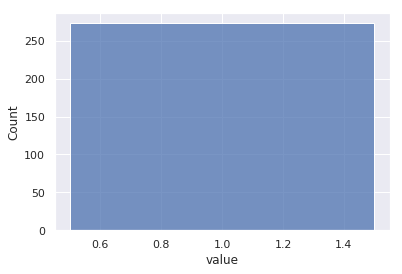





Metric = cco_credentials_mode


,__name__,_id,container,job,mode,namespace,pod,service,timestamp,value
0,cco_credentials_mode,0077bb81-a9a9-4d71-9d07-e9a38f878a01,kube-rbac-proxy,cco-metrics,mint,openshift-cloud-credential-operator,cloud-credential-operator-d687d894b-fr7hz,cco-metrics,1617105600,1
1,cco_credentials_mode,047d5398-e885-43d5-92a7-0dd674e078a2,kube-rbac-proxy,cco-metrics,mint,openshift-cloud-credential-operator,cloud-credential-operator-84874c89cf-22zpq,cco-metrics,1617105600,1
2,cco_credentials_mode,0a64bbdb-6b90-4208-aff5-dec096216f10,kube-rbac-proxy,cco-metrics,mint,openshift-cloud-credential-operator,cloud-credential-operator-776f7ddd5c-zzftn,cco-metrics,1617105600,1
3,cco_credentials_mode,0c476eff-fd51-4759-9128-63c946a83c97,kube-rbac-proxy,cco-metrics,passthrough,openshift-cloud-credential-operator,cloud-credential-operator-864b7d4b9d-4f4s8,cco-metrics,1617105600,1
4,cco_credentials_mode,0db5aad5-7099-4fa5-8dd1-086a6499af5a,kube-rbac-proxy,cco-metrics,mint,openshift-cloud-credential-operator,cloud-credential-operator-65b9c8cb8b-vk779,cco-metrics,1617105600,1


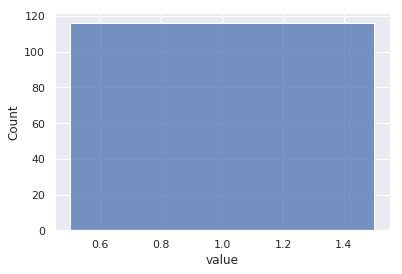





Metric = ceph_cluster_total_bytes


,__name__,_id,container,job,namespace,pod,service,timestamp,value
0,ceph_cluster_total_bytes,52042d3f-96a8-4b7d-a3ce-9c0d4bae88ca,mgr,rook-ceph-mgr,openshift-storage,rook-ceph-mgr-a-56c7747794-6wkzv,rook-ceph-mgr,1617105600,6597069766656


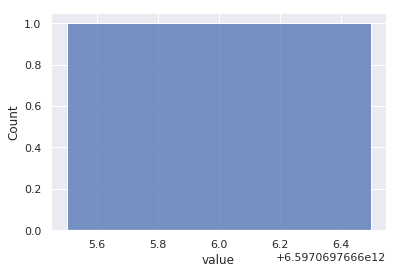





Metric = ceph_cluster_total_used_raw_bytes


,__name__,_id,container,job,namespace,pod,service,timestamp,value
0,ceph_cluster_total_used_raw_bytes,52042d3f-96a8-4b7d-a3ce-9c0d4bae88ca,mgr,rook-ceph-mgr,openshift-storage,rook-ceph-mgr-a-56c7747794-6wkzv,rook-ceph-mgr,1617105600,153042944


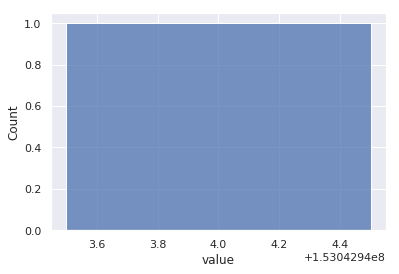





Metric = ceph_health_status


,__name__,_id,container,job,namespace,pod,service,timestamp,value
0,ceph_health_status,52042d3f-96a8-4b7d-a3ce-9c0d4bae88ca,mgr,rook-ceph-mgr,openshift-storage,rook-ceph-mgr-a-56c7747794-6wkzv,rook-ceph-mgr,1617105600,2


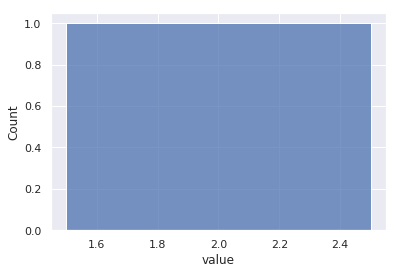





Metric = cluster:apiserver_current_inflight_requests:sum:max_over_time:2m


,__name__,_id,apiserver,timestamp,value,requestKind
0,cluster:apiserver_current_inflight_requests:su...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,kube-apiserver,1617105600,20,NaN
1,cluster:apiserver_current_inflight_requests:su...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,openshift-apiserver,1617105600,5,NaN
2,cluster:apiserver_current_inflight_requests:su...,00b9c122-4ea2-4f4d-9d50-18bd73265905,kube-apiserver,1617105600,11,NaN
3,cluster:apiserver_current_inflight_requests:su...,00b9c122-4ea2-4f4d-9d50-18bd73265905,openshift-apiserver,1617105600,3,NaN
4,cluster:apiserver_current_inflight_requests:su...,047d5398-e885-43d5-92a7-0dd674e078a2,kube-apiserver,1617105600,22,NaN


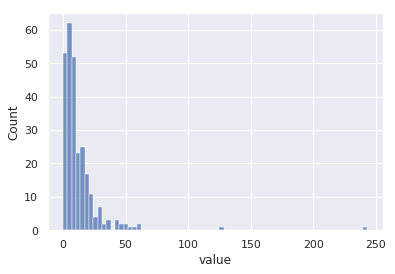





Metric = cluster:capacity_cpu_cores:sum


,__name__,_id,label_beta_kubernetes_io_instance_type,label_kubernetes_io_arch,label_node_openshift_io_os_id,label_node_role_kubernetes_io,timestamp,value
0,cluster:capacity_cpu_cores:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,n1-standard-4,amd64,rhcos,master,1617105600,12
1,cluster:capacity_cpu_cores:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,n1-standard-4,amd64,rhcos,NaN,1617105600,12
2,cluster:capacity_cpu_cores:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,m4.xlarge,amd64,rhcos,master,1617105600,12
3,cluster:capacity_cpu_cores:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,m4.xlarge,amd64,rhcos,NaN,1617105600,12
4,cluster:capacity_cpu_cores:sum,047d5398-e885-43d5-92a7-0dd674e078a2,m4.xlarge,amd64,rhcos,NaN,1617105600,12


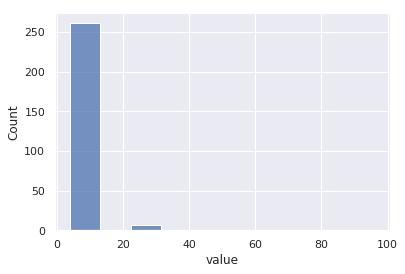





Metric = cluster:capacity_memory_bytes:sum


,__name__,_id,label_beta_kubernetes_io_instance_type,label_node_role_kubernetes_io,timestamp,value
0,cluster:capacity_memory_bytes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,n1-standard-4,master,1617105600,47240671232
1,cluster:capacity_memory_bytes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,n1-standard-4,NaN,1617105600,47240671232
2,cluster:capacity_memory_bytes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,m4.xlarge,master,1617105600,50432831488
3,cluster:capacity_memory_bytes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,m4.xlarge,NaN,1617105600,50433040384
4,cluster:capacity_memory_bytes:sum,047d5398-e885-43d5-92a7-0dd674e078a2,m4.xlarge,NaN,1617105600,50407079936


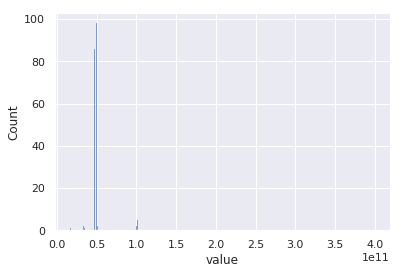





Metric = cluster:cpu_usage_cores:sum


,__name__,_id,timestamp,value
0,cluster:cpu_usage_cores:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,3.5275238095238124
1,cluster:cpu_usage_cores:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,3.7203401831836995
2,cluster:cpu_usage_cores:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,4.178525523874838
3,cluster:cpu_usage_cores:sum,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,2.870607526969527
4,cluster:cpu_usage_cores:sum,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,3.0339047619047714


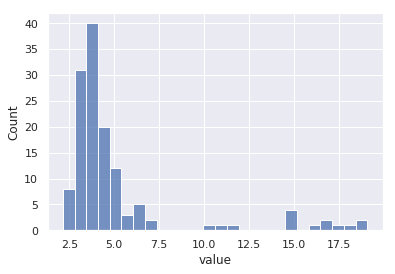





Metric = cluster:kube_persistentvolume_plugin_type_counts:sum


,__name__,_id,plugin_name,volume_mode,timestamp,value
0,cluster:kube_persistentvolume_plugin_type_coun...,047d5398-e885-43d5-92a7-0dd674e078a2,kubernetes.io/aws-ebs,Filesystem,1617105600,4
1,cluster:kube_persistentvolume_plugin_type_coun...,0a64bbdb-6b90-4208-aff5-dec096216f10,kubernetes.io/aws-ebs,Filesystem,1617105600,2
2,cluster:kube_persistentvolume_plugin_type_coun...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,kubernetes.io/aws-ebs,Filesystem,1617105600,4
3,cluster:kube_persistentvolume_plugin_type_coun...,1433564d-58c8-48a4-a723-390be248ef10,kubernetes.io/gce-pd,Filesystem,1617105600,2
4,cluster:kube_persistentvolume_plugin_type_coun...,166885f6-76c6-42c8-8f05-ce1c67986bcf,kubernetes.io/aws-ebs,Filesystem,1617105600,3


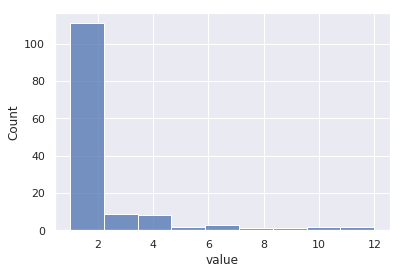





Metric = cluster:kube_persistentvolumeclaim_resource_requests_storage_bytes:provisioner:sum


,__name__,_id,provisioner,timestamp,value
0,cluster:kube_persistentvolumeclaim_resource_re...,00b9c122-4ea2-4f4d-9d50-18bd73265905,kubernetes.io/aws-ebs,1617105600,21474836480
1,cluster:kube_persistentvolumeclaim_resource_re...,047d5398-e885-43d5-92a7-0dd674e078a2,kubernetes.io/aws-ebs,1617105600,53687091200
2,cluster:kube_persistentvolumeclaim_resource_re...,0a64bbdb-6b90-4208-aff5-dec096216f10,kubernetes.io/aws-ebs,1617105600,21474836480
3,cluster:kube_persistentvolumeclaim_resource_re...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,kubernetes.io/aws-ebs,1617105600,53687091200
4,cluster:kube_persistentvolumeclaim_resource_re...,1433564d-58c8-48a4-a723-390be248ef10,kubernetes.io/gce-pd,1617105600,21474836480


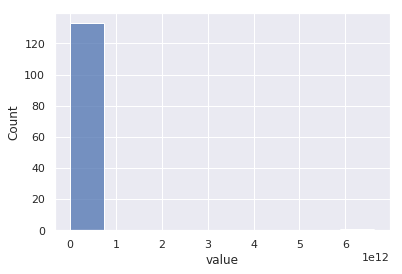





Metric = cluster:kubelet_volume_stats_used_bytes:provisioner:sum


,__name__,_id,provisioner,timestamp,value
0,cluster:kubelet_volume_stats_used_bytes:provis...,00b9c122-4ea2-4f4d-9d50-18bd73265905,kubernetes.io/aws-ebs,1617105600,728248320
1,cluster:kubelet_volume_stats_used_bytes:provis...,047d5398-e885-43d5-92a7-0dd674e078a2,kubernetes.io/aws-ebs,1617105600,4729520128
2,cluster:kubelet_volume_stats_used_bytes:provis...,0a64bbdb-6b90-4208-aff5-dec096216f10,kubernetes.io/aws-ebs,1617105600,1048379392
3,cluster:kubelet_volume_stats_used_bytes:provis...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,kubernetes.io/aws-ebs,1617105600,4269744128
4,cluster:kubelet_volume_stats_used_bytes:provis...,1433564d-58c8-48a4-a723-390be248ef10,kubernetes.io/gce-pd,1617105600,394457088


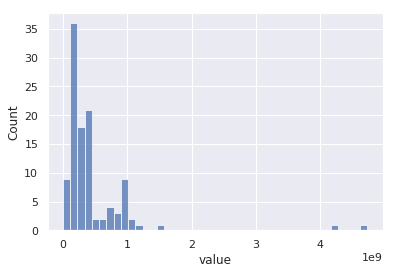





Metric = cluster:memory_usage_bytes:sum


,__name__,_id,timestamp,value
0,cluster:memory_usage_bytes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,30335766528
1,cluster:memory_usage_bytes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,27944071168
2,cluster:memory_usage_bytes:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,31545950208
3,cluster:memory_usage_bytes:sum,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,29788803072
4,cluster:memory_usage_bytes:sum,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,32101343232


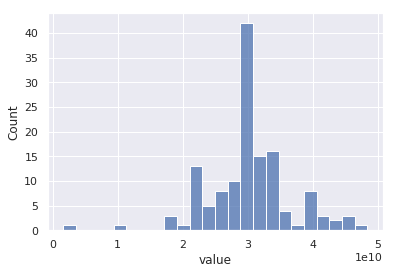





Metric = cluster:network_attachment_definition_enabled_instance_up:max


,__name__,_id,networks,timestamp,value
0,cluster:network_attachment_definition_enabled_...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,any,1617105600,0
1,cluster:network_attachment_definition_enabled_...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,ib-sriov,1617105600,0
2,cluster:network_attachment_definition_enabled_...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,sriov,1617105600,0
3,cluster:network_attachment_definition_enabled_...,00b9c122-4ea2-4f4d-9d50-18bd73265905,any,1617105600,0
4,cluster:network_attachment_definition_enabled_...,00b9c122-4ea2-4f4d-9d50-18bd73265905,ib-sriov,1617105600,0


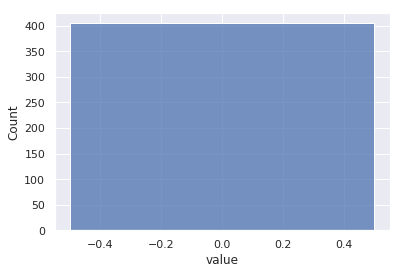





Metric = cluster:network_attachment_definition_instances:max


,__name__,_id,networks,timestamp,value
0,cluster:network_attachment_definition_instance...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,any,1617105600,0
1,cluster:network_attachment_definition_instance...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,ib-sriov,1617105600,0
2,cluster:network_attachment_definition_instance...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,sriov,1617105600,0
3,cluster:network_attachment_definition_instance...,00b9c122-4ea2-4f4d-9d50-18bd73265905,any,1617105600,0
4,cluster:network_attachment_definition_instance...,00b9c122-4ea2-4f4d-9d50-18bd73265905,ib-sriov,1617105600,0


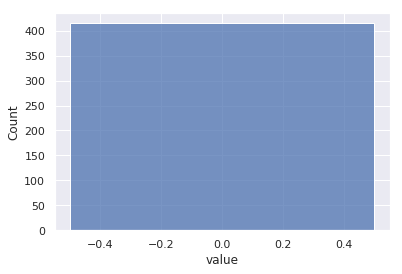





Metric = cluster:node_instance_type_count:sum


,__name__,_id,label_beta_kubernetes_io_instance_type,label_kubernetes_io_arch,label_node_openshift_io_os_id,label_node_role_kubernetes_io,timestamp,value
0,cluster:node_instance_type_count:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,n1-standard-4,amd64,rhcos,master,1617105600,3
1,cluster:node_instance_type_count:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,n1-standard-4,amd64,rhcos,NaN,1617105600,3
2,cluster:node_instance_type_count:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,m4.xlarge,amd64,rhcos,master,1617105600,3
3,cluster:node_instance_type_count:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,m4.xlarge,amd64,rhcos,NaN,1617105600,3
4,cluster:node_instance_type_count:sum,047d5398-e885-43d5-92a7-0dd674e078a2,m4.xlarge,amd64,rhcos,NaN,1617105600,3


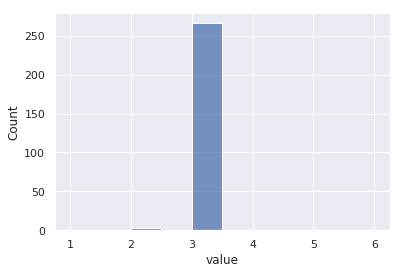





Metric = cluster:telemetry_selected_series:count


,__name__,_id,timestamp,value
0,cluster:telemetry_selected_series:count,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,452
1,cluster:telemetry_selected_series:count,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,430
2,cluster:telemetry_selected_series:count,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,461
3,cluster:telemetry_selected_series:count,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,446
4,cluster:telemetry_selected_series:count,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,452


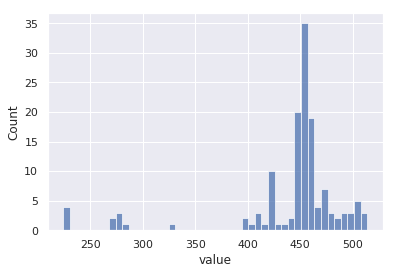





Metric = cluster:usage:containers:sum


,__name__,_id,timestamp,value
0,cluster:usage:containers:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,559
1,cluster:usage:containers:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,347
2,cluster:usage:containers:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,545
3,cluster:usage:containers:sum,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,597
4,cluster:usage:containers:sum,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,840


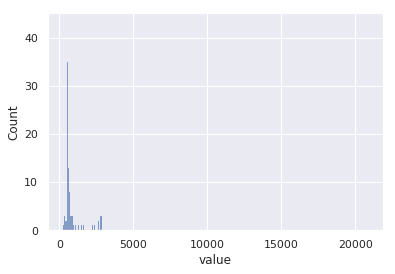





Metric = cluster:usage:ingress_frontend_bytes_in:rate5m:sum


,__name__,_id,timestamp,value
0,cluster:usage:ingress_frontend_bytes_in:rate5m...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,132.72222222222223
1,cluster:usage:ingress_frontend_bytes_in:rate5m...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,113.35185185185185
2,cluster:usage:ingress_frontend_bytes_in:rate5m...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,132.0037037037037
3,cluster:usage:ingress_frontend_bytes_in:rate5m...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,139.04444444444445
4,cluster:usage:ingress_frontend_bytes_in:rate5m...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,123.37037037037035


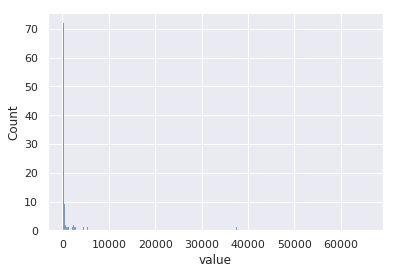





Metric = cluster:usage:ingress_frontend_bytes_out:rate5m:sum


,__name__,_id,timestamp,value
0,cluster:usage:ingress_frontend_bytes_out:rate5...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,462.00370370370376
1,cluster:usage:ingress_frontend_bytes_out:rate5...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,397.61481481481485
2,cluster:usage:ingress_frontend_bytes_out:rate5...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,501.0888888888889
3,cluster:usage:ingress_frontend_bytes_out:rate5...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,484.91111111111115
4,cluster:usage:ingress_frontend_bytes_out:rate5...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,446.7518518518518


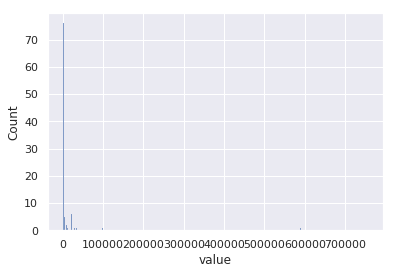





Metric = cluster:usage:ingress_frontend_connections:sum


,__name__,_id,timestamp,value
0,cluster:usage:ingress_frontend_connections:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,0
1,cluster:usage:ingress_frontend_connections:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,14
2,cluster:usage:ingress_frontend_connections:sum,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,7
3,cluster:usage:ingress_frontend_connections:sum,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,5
4,cluster:usage:ingress_frontend_connections:sum,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,14


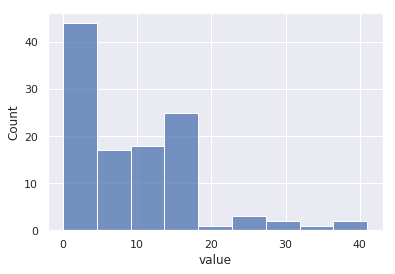





Metric = cluster:usage:kube_node_ready:avg5m


,__name__,_id,timestamp,value
0,cluster:usage:kube_node_ready:avg5m,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,1
1,cluster:usage:kube_node_ready:avg5m,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,1
2,cluster:usage:kube_node_ready:avg5m,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,1
3,cluster:usage:kube_node_ready:avg5m,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,1
4,cluster:usage:kube_node_ready:avg5m,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,1


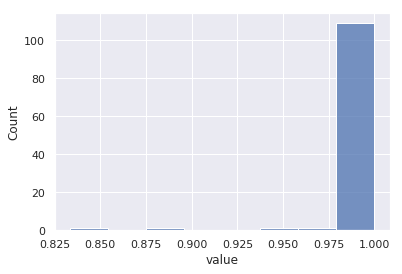





Metric = cluster:usage:kube_schedulable_node_ready_reachable:avg5m


,__name__,_id,timestamp,value
0,cluster:usage:kube_schedulable_node_ready_reac...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,1
1,cluster:usage:kube_schedulable_node_ready_reac...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,1
2,cluster:usage:kube_schedulable_node_ready_reac...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,1
3,cluster:usage:kube_schedulable_node_ready_reac...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,1
4,cluster:usage:kube_schedulable_node_ready_reac...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,1


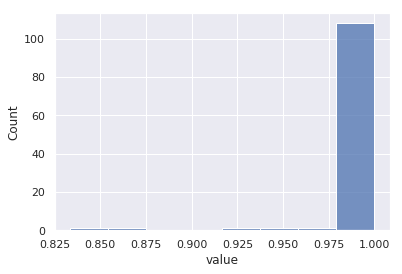





Metric = cluster:usage:openshift:ingress_request_error:fraction5m


,__name__,_id,timestamp,value
0,cluster:usage:openshift:ingress_request_error:...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,0
1,cluster:usage:openshift:ingress_request_error:...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,0
2,cluster:usage:openshift:ingress_request_error:...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,0
3,cluster:usage:openshift:ingress_request_error:...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,0
4,cluster:usage:openshift:ingress_request_error:...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,0


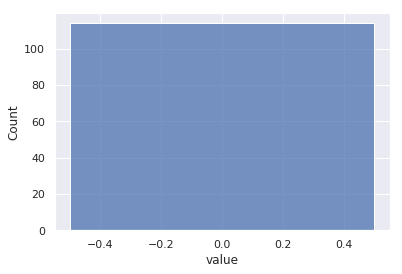





Metric = cluster:usage:openshift:ingress_request_total:irate5m


,__name__,_id,timestamp,value
0,cluster:usage:openshift:ingress_request_total:...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,0.06666666666666667
1,cluster:usage:openshift:ingress_request_total:...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,0.06666666666666667
2,cluster:usage:openshift:ingress_request_total:...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,0.03333333333333333
3,cluster:usage:openshift:ingress_request_total:...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,0.1
4,cluster:usage:openshift:ingress_request_total:...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,0.03333333333333333


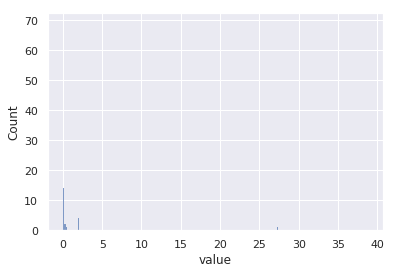





Metric = cluster:usage:openshift:kube_running_pod_ready:avg


,__name__,_id,timestamp,value
0,cluster:usage:openshift:kube_running_pod_ready...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,1
1,cluster:usage:openshift:kube_running_pod_ready...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,1
2,cluster:usage:openshift:kube_running_pod_ready...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,1
3,cluster:usage:openshift:kube_running_pod_ready...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,1
4,cluster:usage:openshift:kube_running_pod_ready...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,1


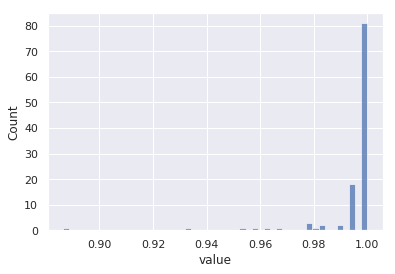





Metric = cluster:usage:pods:terminal:workload:sum


,__name__,_id,timestamp,value
0,cluster:usage:pods:terminal:workload:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,2
1,cluster:usage:pods:terminal:workload:sum,166885f6-76c6-42c8-8f05-ce1c67986bcf,1617105600,19
2,cluster:usage:pods:terminal:workload:sum,21310a56-129f-4c28-bff4-2265003f0691,1617105600,2
3,cluster:usage:pods:terminal:workload:sum,26e5823c-1fc7-46c6-afaa-9a3cd8135f45,1617105600,1
4,cluster:usage:pods:terminal:workload:sum,2b360a37-b0b3-4c49-a15d-861eaea36101,1617105600,16


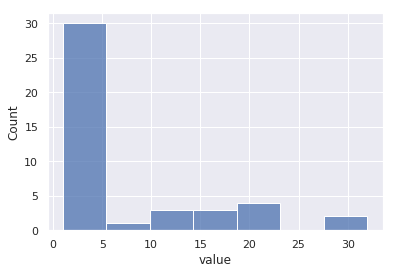





Metric = cluster:usage:resources:sum


,__name__,_id,resource,timestamp,value
0,cluster:usage:resources:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,alertmanagerconfigs.monitoring.coreos.com,1617105600,0
1,cluster:usage:resources:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,alertmanagers.monitoring.coreos.com,1617105600,1
2,cluster:usage:resources:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,apiservers.config.openshift.io,1617105600,1
3,cluster:usage:resources:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,apiservices.apiregistration.k8s.io,1617105600,79
4,cluster:usage:resources:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,authentications.config.openshift.io,1617105600,1


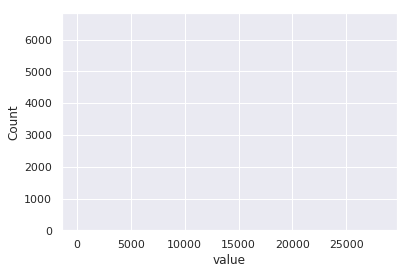





Metric = cluster:usage:workload:capacity_physical_cpu_core_seconds


,__name__,_id,timestamp,value
0,cluster:usage:workload:capacity_physical_cpu_c...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,41364
1,cluster:usage:workload:capacity_physical_cpu_c...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,5364
2,cluster:usage:workload:capacity_physical_cpu_c...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,64602
3,cluster:usage:workload:capacity_physical_cpu_c...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,39564
4,cluster:usage:workload:capacity_physical_cpu_c...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,7164


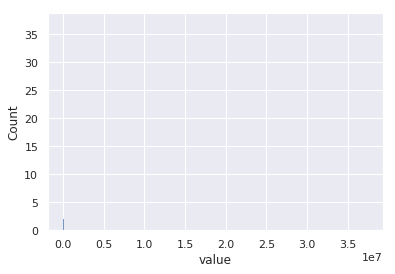





Metric = cluster:usage:workload:capacity_physical_cpu_cores:max:5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:capacity_physical_cpu_c...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,6
1,cluster:usage:workload:capacity_physical_cpu_c...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,6
2,cluster:usage:workload:capacity_physical_cpu_c...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,6
3,cluster:usage:workload:capacity_physical_cpu_c...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,12
4,cluster:usage:workload:capacity_physical_cpu_c...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,6


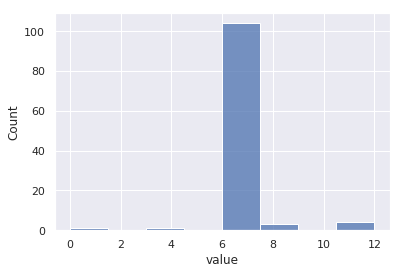





Metric = cluster:usage:workload:capacity_physical_cpu_cores:min:5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:capacity_physical_cpu_c...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,6
1,cluster:usage:workload:capacity_physical_cpu_c...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,6
2,cluster:usage:workload:capacity_physical_cpu_c...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,6
3,cluster:usage:workload:capacity_physical_cpu_c...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,12
4,cluster:usage:workload:capacity_physical_cpu_c...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,6


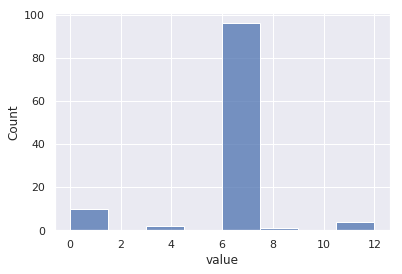





Metric = cluster:usage:workload:ingress_request_error:fraction5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:ingress_request_error:f...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,0
1,cluster:usage:workload:ingress_request_error:f...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,0
2,cluster:usage:workload:ingress_request_error:f...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,0
3,cluster:usage:workload:ingress_request_error:f...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,0
4,cluster:usage:workload:ingress_request_error:f...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,0


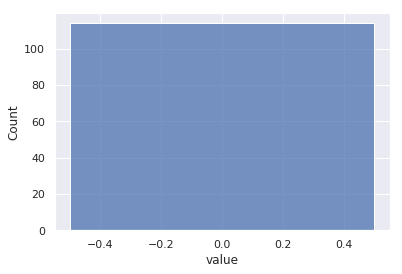





Metric = cluster:usage:workload:ingress_request_total:irate5m


,__name__,_id,timestamp,value
0,cluster:usage:workload:ingress_request_total:i...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,0
1,cluster:usage:workload:ingress_request_total:i...,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,0
2,cluster:usage:workload:ingress_request_total:i...,0a64bbdb-6b90-4208-aff5-dec096216f10,1617105600,0
3,cluster:usage:workload:ingress_request_total:i...,0c476eff-fd51-4759-9128-63c946a83c97,1617105600,0
4,cluster:usage:workload:ingress_request_total:i...,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,0


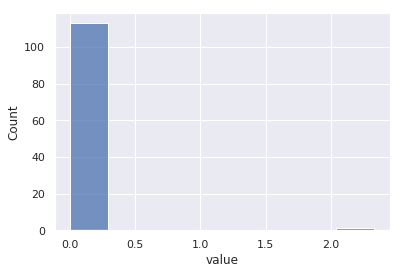





Metric = cluster:usage:workload:kube_running_pod_ready:avg


,__name__,_id,timestamp,value
0,cluster:usage:workload:kube_running_pod_ready:avg,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,1
1,cluster:usage:workload:kube_running_pod_ready:avg,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,0.75
2,cluster:usage:workload:kube_running_pod_ready:avg,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,0.8
3,cluster:usage:workload:kube_running_pod_ready:avg,1433564d-58c8-48a4-a723-390be248ef10,1617105600,1
4,cluster:usage:workload:kube_running_pod_ready:avg,166885f6-76c6-42c8-8f05-ce1c67986bcf,1617105600,0.7799999999999997


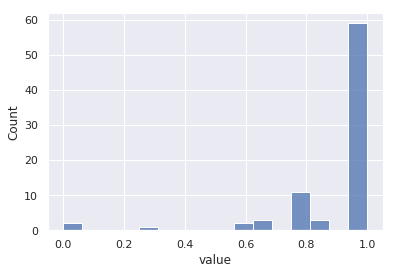





Metric = cluster:virt_platform_nodes:sum


,__name__,_id,type,timestamp,value,baseboard_manufacturer,baseboard_product_name,system_manufacturer,system_product_name
0,cluster:virt_platform_nodes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,gcp,1617105600,6,NaN,NaN,NaN,NaN
1,cluster:virt_platform_nodes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,kvm,1617105600,6,NaN,NaN,NaN,NaN
2,cluster:virt_platform_nodes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,aws,1617105600,6,NaN,NaN,NaN,NaN
3,cluster:virt_platform_nodes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,xen,1617105600,6,NaN,NaN,NaN,NaN
4,cluster:virt_platform_nodes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,xen-hvm,1617105600,6,NaN,NaN,NaN,NaN


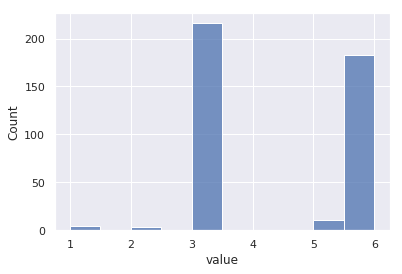





Metric = cluster:vsphere_esxi_version_total:sum


,__name__,_id,version,timestamp,value
0,cluster:vsphere_esxi_version_total:sum,0c476eff-fd51-4759-9128-63c946a83c97,7.0.1,1617105600,4
1,cluster:vsphere_esxi_version_total:sum,4aba7c80-a254-485e-aedb-462beab753e3,7.0.1,1617105600,3
2,cluster:vsphere_esxi_version_total:sum,a592f4df-90d3-4fa1-9000-4c23e29ae13b,7.0.1,1617105600,3
3,cluster:vsphere_esxi_version_total:sum,e8709d33-31b4-4de3-83d1-4b7a1d019d62,7.0.1,1617105600,2


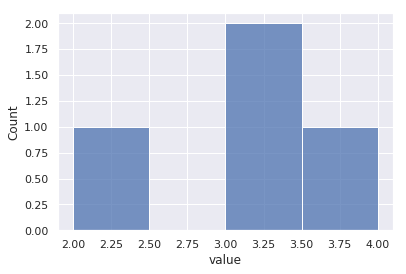





Metric = cluster:vsphere_node_hw_version_total:sum


,__name__,_id,hw_version,timestamp,value
0,cluster:vsphere_node_hw_version_total:sum,0c476eff-fd51-4759-9128-63c946a83c97,vmx-13,1617105600,6
1,cluster:vsphere_node_hw_version_total:sum,4aba7c80-a254-485e-aedb-462beab753e3,vmx-13,1617105600,3
2,cluster:vsphere_node_hw_version_total:sum,a592f4df-90d3-4fa1-9000-4c23e29ae13b,vmx-13,1617105600,6
3,cluster:vsphere_node_hw_version_total:sum,e8709d33-31b4-4de3-83d1-4b7a1d019d62,vmx-13,1617105600,4


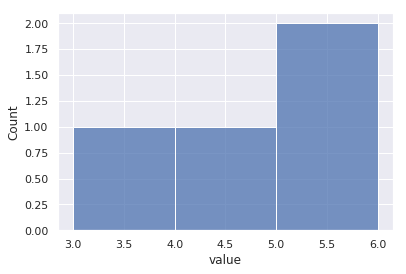





Metric = cluster:vsphere_vcenter_info:sum


,__name__,_id,version,timestamp,value
0,cluster:vsphere_vcenter_info:sum,0c476eff-fd51-4759-9128-63c946a83c97,7.0.1,1617105600,1
1,cluster:vsphere_vcenter_info:sum,4aba7c80-a254-485e-aedb-462beab753e3,7.0.1,1617105600,1
2,cluster:vsphere_vcenter_info:sum,a592f4df-90d3-4fa1-9000-4c23e29ae13b,7.0.1,1617105600,1
3,cluster:vsphere_vcenter_info:sum,e8709d33-31b4-4de3-83d1-4b7a1d019d62,7.0.1,1617105600,1


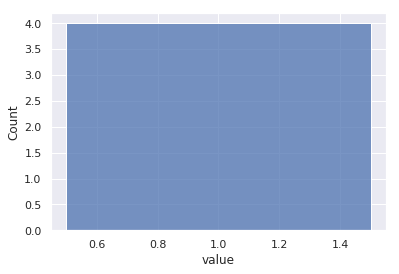





Metric = cluster_feature_set


,__name__,_id,container,job,namespace,pod,service,timestamp,value
0,cluster_feature_set,0077bb81-a9a9-4d71-9d07-e9a38f878a01,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-769bd866d-rjvr7,metrics,1617105600,1
1,cluster_feature_set,00b9c122-4ea2-4f4d-9d50-18bd73265905,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-6d4b479bcb-s8xpn,metrics,1617105600,1
2,cluster_feature_set,047d5398-e885-43d5-92a7-0dd674e078a2,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-5877d969f-jqfrj,metrics,1617105600,1
3,cluster_feature_set,0a64bbdb-6b90-4208-aff5-dec096216f10,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-7df6755578-kvlt8,metrics,1617105600,1
4,cluster_feature_set,0c476eff-fd51-4759-9128-63c946a83c97,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-58964bcdf-dfndq,metrics,1617105600,1


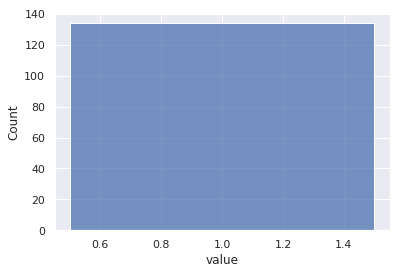





Metric = cluster_infrastructure_provider


,__name__,_id,container,job,namespace,pod,region,service,type,timestamp,value
0,cluster_infrastructure_provider,0077bb81-a9a9-4d71-9d07-e9a38f878a01,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-769bd866d-rjvr7,us-east1,metrics,GCP,1617105600,1
1,cluster_infrastructure_provider,00b9c122-4ea2-4f4d-9d50-18bd73265905,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-6d4b479bcb-s8xpn,us-east-1,metrics,AWS,1617105600,1
2,cluster_infrastructure_provider,047d5398-e885-43d5-92a7-0dd674e078a2,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-5877d969f-jqfrj,us-west-2,metrics,AWS,1617105600,1
3,cluster_infrastructure_provider,0a64bbdb-6b90-4208-aff5-dec096216f10,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-7df6755578-kvlt8,us-west-2,metrics,AWS,1617105600,1
4,cluster_infrastructure_provider,0c476eff-fd51-4759-9128-63c946a83c97,kube-apiserver-operator,metrics,openshift-kube-apiserver-operator,kube-apiserver-operator-58964bcdf-dfndq,NaN,metrics,VSphere,1617105600,1


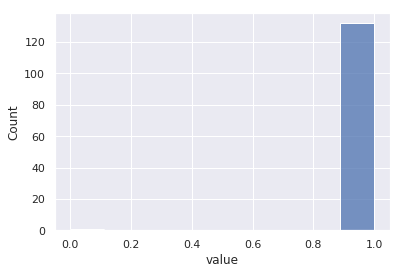





Metric = cluster_installer


,__name__,_id,invoker,job,namespace,pod,service,type,version,timestamp,value
0,cluster_installer,0077bb81-a9a9-4d71-9d07-e9a38f878a01,openshift-internal-ci/release-openshift-origin...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,openshift-install,unreleased-master-4436-g6363f3ab700e3976e8655b...,1617105600,1
1,cluster_installer,00b9c122-4ea2-4f4d-9d50-18bd73265905,openshift-internal-ci/periodic-ci-openshift-re...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-58d859d6d8-jrg9c,cluster-version-operator,openshift-install,v4.5.0,1617105600,1
2,cluster_installer,047d5398-e885-43d5-92a7-0dd674e078a2,openshift-internal-ci/pull-ci-openshift-assist...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-57688fddbd-4m8cs,cluster-version-operator,openshift-install,unreleased-master-4436-g6363f3ab700e3976e8655b...,1617105600,1
3,cluster_installer,0a64bbdb-6b90-4208-aff5-dec096216f10,openshift-internal-ci/pull-ci-che-incubator-ch...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-79477d9f58-9pxf4,cluster-version-operator,openshift-install,v4.7.0,1617105600,1
4,cluster_installer,0c476eff-fd51-4759-9128-63c946a83c97,openshift-internal-ci/e2e-vsphere-upi-serial/1...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-7b9b5ff564-g5zgn,cluster-version-operator,other,unreleased-master-4196-ge15f17c958b4a04e770c0c...,1617105600,1


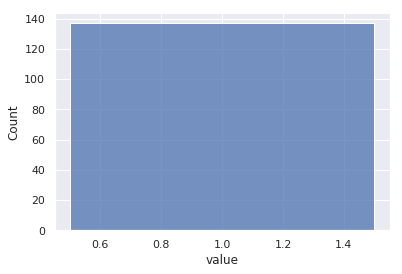





Metric = cluster_legacy_scheduler_policy


,__name__,_id,job,namespace,pod,service,timestamp,value
0,cluster_legacy_scheduler_policy,0077bb81-a9a9-4d71-9d07-e9a38f878a01,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-8b95f65fd-n8qzr,metrics,1617105600,0
1,cluster_legacy_scheduler_policy,00b9c122-4ea2-4f4d-9d50-18bd73265905,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-86758698-6m8hd,metrics,1617105600,0
2,cluster_legacy_scheduler_policy,047d5398-e885-43d5-92a7-0dd674e078a2,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-646b98f769-2...,metrics,1617105600,0
3,cluster_legacy_scheduler_policy,0a64bbdb-6b90-4208-aff5-dec096216f10,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-df45ffbd-j44gr,metrics,1617105600,0
4,cluster_legacy_scheduler_policy,0c476eff-fd51-4759-9128-63c946a83c97,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-69d4489c55-m...,metrics,1617105600,0


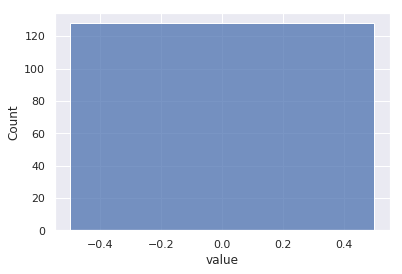





Metric = cluster_master_schedulable


,__name__,_id,job,namespace,pod,service,timestamp,value
0,cluster_master_schedulable,0077bb81-a9a9-4d71-9d07-e9a38f878a01,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-8b95f65fd-n8qzr,metrics,1617105600,0
1,cluster_master_schedulable,00b9c122-4ea2-4f4d-9d50-18bd73265905,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-86758698-6m8hd,metrics,1617105600,0
2,cluster_master_schedulable,047d5398-e885-43d5-92a7-0dd674e078a2,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-646b98f769-2...,metrics,1617105600,0
3,cluster_master_schedulable,0a64bbdb-6b90-4208-aff5-dec096216f10,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-df45ffbd-j44gr,metrics,1617105600,0
4,cluster_master_schedulable,0c476eff-fd51-4759-9128-63c946a83c97,metrics,openshift-kube-scheduler-operator,openshift-kube-scheduler-operator-69d4489c55-m...,metrics,1617105600,0


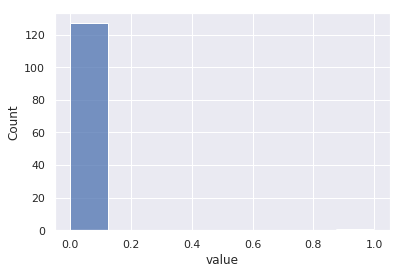





Metric = cluster_operator_conditions


,__name__,_id,condition,job,name,namespace,pod,reason,service,timestamp,value
0,cluster_operator_conditions,0077bb81-a9a9-4d71-9d07-e9a38f878a01,Available,cluster-version-operator,authentication,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,AsExpected,cluster-version-operator,1617105600,1
1,cluster_operator_conditions,0077bb81-a9a9-4d71-9d07-e9a38f878a01,Available,cluster-version-operator,baremetal,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,AsExpected,cluster-version-operator,1617105600,1
2,cluster_operator_conditions,0077bb81-a9a9-4d71-9d07-e9a38f878a01,Available,cluster-version-operator,cloud-controller-manager,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,AsExpected,cluster-version-operator,1617105600,1
3,cluster_operator_conditions,0077bb81-a9a9-4d71-9d07-e9a38f878a01,Available,cluster-version-operator,cloud-credential,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,NaN,cluster-version-operator,1617105600,1
4,cluster_operator_conditions,0077bb81-a9a9-4d71-9d07-e9a38f878a01,Available,cluster-version-operator,cluster-autoscaler,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,AsExpected,cluster-version-operator,1617105600,1


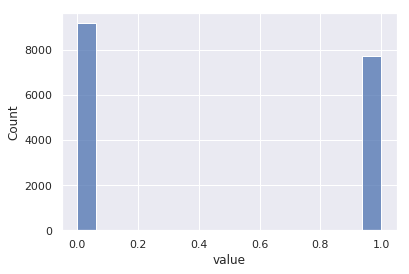





Metric = cluster_operator_up


,__name__,_id,job,name,namespace,pod,service,version,timestamp,value
0,cluster_operator_up,0077bb81-a9a9-4d71-9d07-e9a38f878a01,cluster-version-operator,authentication,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,4.8.0-0.ci-2021-03-30-063145,1617105600,1
1,cluster_operator_up,0077bb81-a9a9-4d71-9d07-e9a38f878a01,cluster-version-operator,baremetal,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,4.8.0-0.ci-2021-03-30-063145,1617105600,1
2,cluster_operator_up,0077bb81-a9a9-4d71-9d07-e9a38f878a01,cluster-version-operator,cloud-controller-manager,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,4.8.0-0.ci-2021-03-30-063145,1617105600,1
3,cluster_operator_up,0077bb81-a9a9-4d71-9d07-e9a38f878a01,cluster-version-operator,cloud-credential,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,4.8.0-0.ci-2021-03-30-063145,1617105600,1
4,cluster_operator_up,0077bb81-a9a9-4d71-9d07-e9a38f878a01,cluster-version-operator,cluster-autoscaler,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,4.8.0-0.ci-2021-03-30-063145,1617105600,1


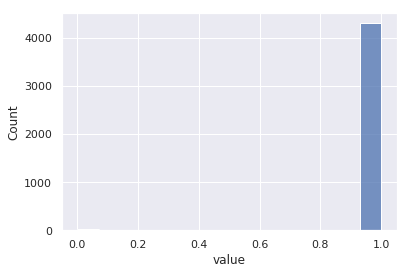





Metric = cluster_version


,__name__,_id,from_version,image,job,namespace,pod,service,type,version,timestamp,value
0,cluster_version,0077bb81-a9a9-4d71-9d07-e9a38f878a01,4.8.0-0.ci-2021-03-30-063145,registry.ci.openshift.org/ocp/release@sha256:d...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,cluster,4.8.0-0.ci-2021-03-30-063145,1617105600,1617097250
1,cluster_version,0077bb81-a9a9-4d71-9d07-e9a38f878a01,4.8.0-0.ci-2021-03-30-063145,registry.ci.openshift.org/ocp/release@sha256:d...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,current,4.8.0-0.ci-2021-03-30-063145,1617105600,1617086261
2,cluster_version,0077bb81-a9a9-4d71-9d07-e9a38f878a01,NaN,registry.ci.openshift.org/ocp/release@sha256:d...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,completed,4.8.0-0.ci-2021-03-30-063145,1617105600,1617098948
3,cluster_version,0077bb81-a9a9-4d71-9d07-e9a38f878a01,NaN,registry.ci.openshift.org/ocp/release@sha256:d...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,initial,4.8.0-0.ci-2021-03-30-063145,1617105600,1617097250
4,cluster_version,00b9c122-4ea2-4f4d-9d50-18bd73265905,4.5.36,registry.build02.ci.openshift.org/ci-op-2nrxbx...,cluster-version-operator,openshift-cluster-version,cluster-version-operator-58d859d6d8-jrg9c,cluster-version-operator,cluster,4.6.0-0.ci-2021-03-29-224732,1617105600,1617098772


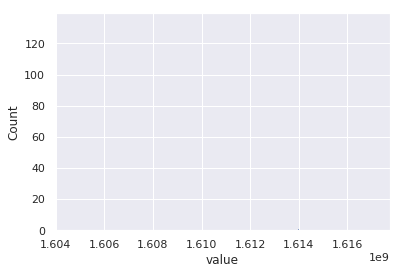





Metric = cluster_version_available_updates


,__name__,_id,job,namespace,pod,service,upstream,timestamp,value,channel
0,cluster_version_available_updates,00b9c122-4ea2-4f4d-9d50-18bd73265905,cluster-version-operator,openshift-cluster-version,cluster-version-operator-58d859d6d8-jrg9c,cluster-version-operator,https://api.openshift.com/api/upgrades_info/v1...,1617105600,0,NaN
1,cluster_version_available_updates,21b0c133-0c05-4df9-b4f0-94edac50cb88,cluster-version-operator,openshift-cluster-version,cluster-version-operator-5966dd7d78-6fv7n,cluster-version-operator,https://api.openshift.com/api/upgrades_info/v1...,1617105600,0,NaN
2,cluster_version_available_updates,30ecad59-642b-40e5-aa01-21456b405ca4,cluster-version-operator,openshift-cluster-version,cluster-version-operator-7dc4d66d8f-gwjm7,cluster-version-operator,https://api.openshift.com/api/upgrades_info/v1...,1617105600,0,NaN
3,cluster_version_available_updates,4349e9d2-e812-49c4-ad5e-85e1df45d8fb,cluster-version-operator,openshift-cluster-version,cluster-version-operator-6876969d85-fqsqt,cluster-version-operator,https://origin-release.svc.ci.openshift.org/graph,1617105600,0,NaN
4,cluster_version_available_updates,4359f481-c03a-4d50-ae98-1c20f4e6e380,cluster-version-operator,openshift-cluster-version,cluster-version-operator-bcd88fdf-fs5l8,cluster-version-operator,https://api.openshift.com/api/upgrades_info/v1...,1617105600,0,NaN


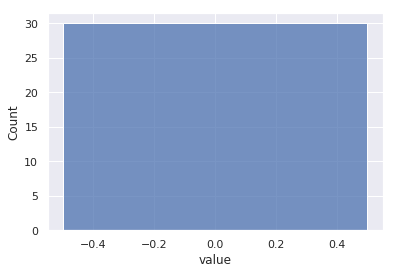





Metric = cluster_version_payload


,__name__,_id,job,namespace,pod,service,type,version,timestamp,value
0,cluster_version_payload,0077bb81-a9a9-4d71-9d07-e9a38f878a01,cluster-version-operator,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,applied,4.8.0-0.ci-2021-03-30-063145,1617105600,692
1,cluster_version_payload,0077bb81-a9a9-4d71-9d07-e9a38f878a01,cluster-version-operator,openshift-cluster-version,cluster-version-operator-86f65544db-k5vgc,cluster-version-operator,pending,4.8.0-0.ci-2021-03-30-063145,1617105600,0
2,cluster_version_payload,00b9c122-4ea2-4f4d-9d50-18bd73265905,cluster-version-operator,openshift-cluster-version,cluster-version-operator-58d859d6d8-jrg9c,cluster-version-operator,applied,4.6.0-0.ci-2021-03-29-224732,1617105600,620
3,cluster_version_payload,00b9c122-4ea2-4f4d-9d50-18bd73265905,cluster-version-operator,openshift-cluster-version,cluster-version-operator-58d859d6d8-jrg9c,cluster-version-operator,pending,4.6.0-0.ci-2021-03-29-224732,1617105600,0
4,cluster_version_payload,047d5398-e885-43d5-92a7-0dd674e078a2,cluster-version-operator,openshift-cluster-version,cluster-version-operator-57688fddbd-4m8cs,cluster-version-operator,applied,4.8.0-0.ci.test-2021-03-30-111127-ci-op-6yvy5xng,1617105600,448


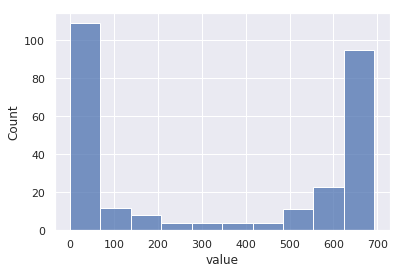





Metric = code:apiserver_request_count:rate:sum


,__name__,_id,code,timestamp,value
0,code:apiserver_request_count:rate:sum,abbcb82a-ccd0-45ff-bd68-6462d6c61f77,0,1617105600,2.950493020102591
1,code:apiserver_request_count:rate:sum,abbcb82a-ccd0-45ff-bd68-6462d6c61f77,200,1617105600,39.71885592854112
2,code:apiserver_request_count:rate:sum,abbcb82a-ccd0-45ff-bd68-6462d6c61f77,201,1617105600,5.690596047785338
3,code:apiserver_request_count:rate:sum,abbcb82a-ccd0-45ff-bd68-6462d6c61f77,403,1617105600,0
4,code:apiserver_request_count:rate:sum,abbcb82a-ccd0-45ff-bd68-6462d6c61f77,404,1617105600,1.5778618565531473


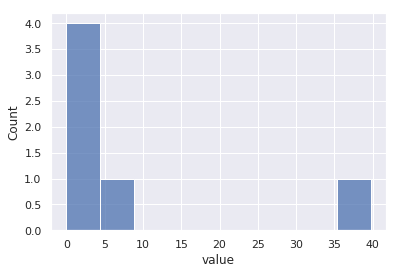





Metric = code:apiserver_request_total:rate:sum


,__name__,_id,code,timestamp,value
0,code:apiserver_request_total:rate:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,0,1617105600,16.763157894736782
1,code:apiserver_request_total:rate:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,200,1617105600,77.77192982456135
2,code:apiserver_request_total:rate:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,201,1617105600,7.008771929824562
3,code:apiserver_request_total:rate:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,404,1617105600,7.999999999999998
4,code:apiserver_request_total:rate:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,409,1617105600,0.09122807017543859


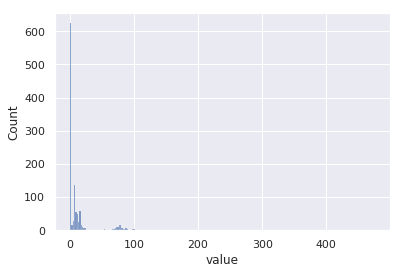





Metric = console_url


,__name__,_id,job,namespace,pod,service,timestamp,value
0,console_url,0077bb81-a9a9-4d71-9d07-e9a38f878a01,metrics,openshift-console-operator,console-operator-66b5df9d56-h52kd,metrics,1617105600,1
1,console_url,00b9c122-4ea2-4f4d-9d50-18bd73265905,metrics,openshift-console-operator,console-operator-85dbc85ccb-kqvd2,metrics,1617105600,1
2,console_url,047d5398-e885-43d5-92a7-0dd674e078a2,metrics,openshift-console-operator,console-operator-6cf7cf895c-fwxpj,metrics,1617105600,1
3,console_url,0a64bbdb-6b90-4208-aff5-dec096216f10,metrics,openshift-console-operator,console-operator-8489978f8-667h2,metrics,1617105600,1
4,console_url,0c476eff-fd51-4759-9128-63c946a83c97,metrics,openshift-console-operator,console-operator-67b6dff79-6tnmm,metrics,1617105600,1


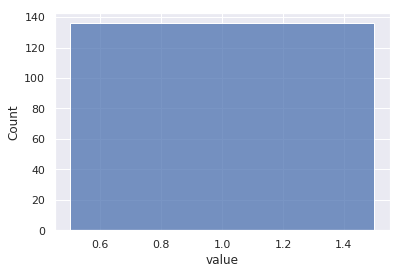





Metric = count:up0


,__name__,_id,job,namespace,service,timestamp,value,container,metrics_path
0,count:up0,53bc31aa-5043-4993-b2a9-b08bfb316aa7,etcd,openshift-etcd,etcd,1617105600,1,NaN,NaN
1,count:up0,5e5c6322-8013-464e-814c-13d46a43dd43,etcd,openshift-etcd,etcd,1617105600,1,NaN,NaN
2,count:up0,88f333ca-6ec2-415f-9309-abc0b870a008,node-exporter,openshift-monitoring,node-exporter,1617105600,2,kube-rbac-proxy,NaN
3,count:up0,88f333ca-6ec2-415f-9309-abc0b870a008,dns-default,openshift-dns,dns-default,1617105600,1,kube-rbac-proxy,NaN
4,count:up0,88f333ca-6ec2-415f-9309-abc0b870a008,network-metrics-service,openshift-multus,network-metrics-service,1617105600,2,kube-rbac-proxy,NaN


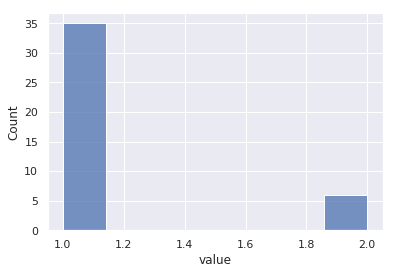





Metric = count:up1


,__name__,_id,apiserver,job,namespace,service,timestamp,value,container,metrics_path
0,count:up1,0077bb81-a9a9-4d71-9d07-e9a38f878a01,kube-apiserver,apiserver,default,kubernetes,1617105600,3,NaN,NaN
1,count:up1,0077bb81-a9a9-4d71-9d07-e9a38f878a01,openshift-apiserver,api,openshift-apiserver,api,1617105600,3,openshift-apiserver,NaN
2,count:up1,0077bb81-a9a9-4d71-9d07-e9a38f878a01,NaN,alertmanager-main,openshift-monitoring,alertmanager-main,1617105600,3,alertmanager-proxy,NaN
3,count:up1,0077bb81-a9a9-4d71-9d07-e9a38f878a01,NaN,catalog-operator-metrics,openshift-operator-lifecycle-manager,catalog-operator-metrics,1617105600,1,catalog-operator,NaN
4,count:up1,0077bb81-a9a9-4d71-9d07-e9a38f878a01,NaN,image-registry-operator,openshift-image-registry,image-registry-operator,1617105600,1,cluster-image-registry-operator,NaN


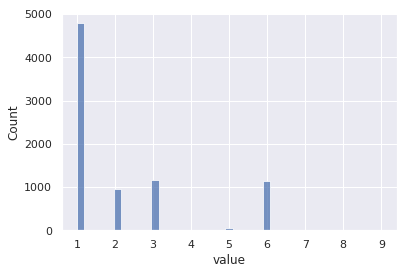





Metric = csv_abnormal


,__name__,_id,container,exported_namespace,job,name,namespace,phase,pod,reason,service,version,timestamp,value
0,csv_abnormal,52042d3f-96a8-4b7d-a3ce-9c0d4bae88ca,olm-operator,openshift-storage,olm-operator-metrics,ocs-operator.v4.8.0,openshift-operator-lifecycle-manager,Installing,olm-operator-74bf6bc846-cvtxg,InstallWaiting,olm-operator-metrics,4.8.0,1617105600,1
1,csv_abnormal,9e159575-2410-4348-8cab-90e35bd293f4,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,Installing,olm-operator-b467fd546-k9jpn,InstallWaiting,olm-operator-metrics,0.17.0,1617105600,1
2,csv_abnormal,bdcdc6f7-1a86-4212-8c1b-a3b18b1d5c5a,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,Installing,olm-operator-69d9754b79-mphjb,InstallSucceeded,olm-operator-metrics,0.17.0,1617105600,1
3,csv_abnormal,c35cf1c8-3d0f-4e9d-a781-bfebd8d1dec1,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,Installing,olm-operator-5bd8fc6984-97hkh,InstallWaiting,olm-operator-metrics,0.17.0,1617105600,1


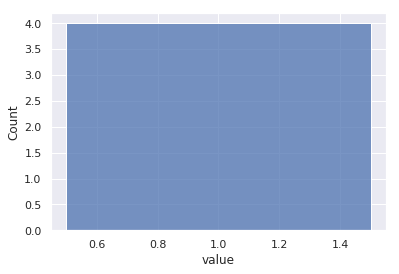





Metric = csv_succeeded


,__name__,_id,container,exported_namespace,job,name,namespace,pod,service,version,timestamp,value
0,csv_succeeded,0077bb81-a9a9-4d71-9d07-e9a38f878a01,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,olm-operator-68cc8f59c8-vkwkb,olm-operator-metrics,0.17.0,1617105600,1
1,csv_succeeded,00b9c122-4ea2-4f4d-9d50-18bd73265905,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,olm-operator-674c695599-twtmp,olm-operator-metrics,0.16.1,1617105600,1
2,csv_succeeded,047d5398-e885-43d5-92a7-0dd674e078a2,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,olm-operator-7cb69dc8cf-fhpth,olm-operator-metrics,0.17.0,1617105600,1
3,csv_succeeded,0a64bbdb-6b90-4208-aff5-dec096216f10,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,olm-operator-54fb4f5b54-k8bdg,olm-operator-metrics,0.17.0,1617105600,1
4,csv_succeeded,0c476eff-fd51-4759-9128-63c946a83c97,olm-operator,openshift-operator-lifecycle-manager,olm-operator-metrics,packageserver,openshift-operator-lifecycle-manager,olm-operator-7987f96b9d-vzr9v,olm-operator-metrics,0.17.0,1617105600,1


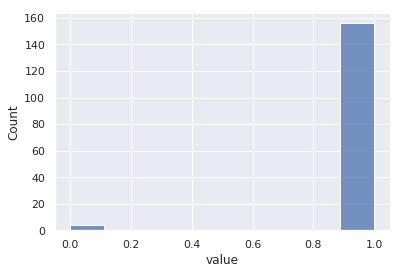





Metric = id_code:apiserver_request_error_rate_sum:max


,__name__,_id,code,timestamp,value
0,id_code:apiserver_request_error_rate_sum:max,abbcb82a-ccd0-45ff-bd68-6462d6c61f77,404,1617105600,1.5778618565531473


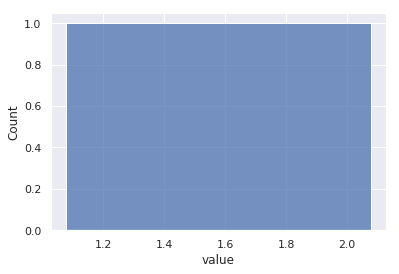





Metric = id_install_type


,__name__,_id,install_type,timestamp,value
0,id_install_type,0077bb81-a9a9-4d71-9d07-e9a38f878a01,ipi,1617105600,0
1,id_install_type,00b9c122-4ea2-4f4d-9d50-18bd73265905,ipi,1617105600,0
2,id_install_type,047d5398-e885-43d5-92a7-0dd674e078a2,ipi,1617105600,0
3,id_install_type,0a64bbdb-6b90-4208-aff5-dec096216f10,ipi,1617105600,0
4,id_install_type,0c476eff-fd51-4759-9128-63c946a83c97,upi,1617105600,0


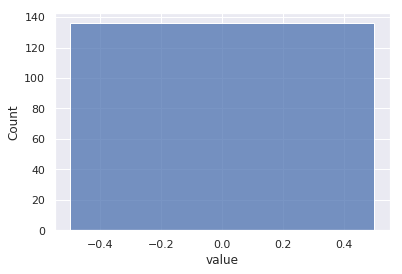





Metric = id_primary_host_type


,__name__,_id,host_type,timestamp,value
0,id_primary_host_type,0077bb81-a9a9-4d71-9d07-e9a38f878a01,gcp,1617105600,0
1,id_primary_host_type,00b9c122-4ea2-4f4d-9d50-18bd73265905,aws,1617105600,0
2,id_primary_host_type,047d5398-e885-43d5-92a7-0dd674e078a2,aws,1617105600,0
3,id_primary_host_type,0a64bbdb-6b90-4208-aff5-dec096216f10,aws,1617105600,0
4,id_primary_host_type,0c476eff-fd51-4759-9128-63c946a83c97,vmware,1617105600,0


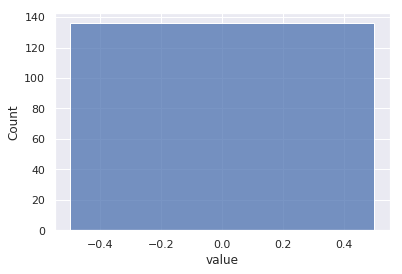





Metric = id_provider


,__name__,_id,provider,timestamp,value
0,id_provider,0077bb81-a9a9-4d71-9d07-e9a38f878a01,GCP,1617105600,0
1,id_provider,00b9c122-4ea2-4f4d-9d50-18bd73265905,AWS,1617105600,0
2,id_provider,047d5398-e885-43d5-92a7-0dd674e078a2,AWS,1617105600,0
3,id_provider,0a64bbdb-6b90-4208-aff5-dec096216f10,AWS,1617105600,0
4,id_provider,0c476eff-fd51-4759-9128-63c946a83c97,VSphere,1617105600,0


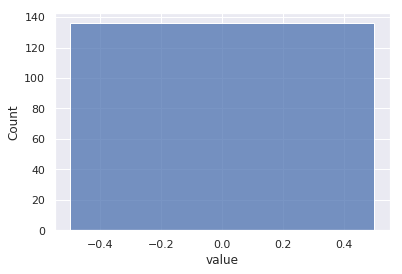





Metric = id_version


,__name__,_id,version,timestamp,value
0,id_version,0077bb81-a9a9-4d71-9d07-e9a38f878a01,4.8.0-0.ci-2021-03-30-063145,1617105600,0
1,id_version,00b9c122-4ea2-4f4d-9d50-18bd73265905,4.6.0-0.ci-2021-03-29-224732,1617105600,0
2,id_version,047d5398-e885-43d5-92a7-0dd674e078a2,4.8.0-0.ci.test-2021-03-30-111127-ci-op-6yvy5xng,1617105600,0
3,id_version,0a64bbdb-6b90-4208-aff5-dec096216f10,4.7.2,1617105600,0
4,id_version,0c476eff-fd51-4759-9128-63c946a83c97,4.7.0-0.nightly-2021-03-27-082615,1617105600,0


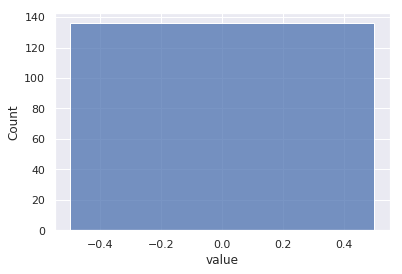





Metric = id_version:cluster_available


,__name__,_id,version,timestamp,value
0,id_version:cluster_available,0077bb81-a9a9-4d71-9d07-e9a38f878a01,4.8.0-0.ci-2021-03-30-063145,1617105600,1
1,id_version:cluster_available,00b9c122-4ea2-4f4d-9d50-18bd73265905,4.6.0-0.ci-2021-03-29-224732,1617105600,0
2,id_version:cluster_available,047d5398-e885-43d5-92a7-0dd674e078a2,4.8.0-0.ci.test-2021-03-30-111127-ci-op-6yvy5xng,1617105600,0
3,id_version:cluster_available,0a64bbdb-6b90-4208-aff5-dec096216f10,4.7.2,1617105600,1
4,id_version:cluster_available,0c476eff-fd51-4759-9128-63c946a83c97,4.7.0-0.nightly-2021-03-27-082615,1617105600,1


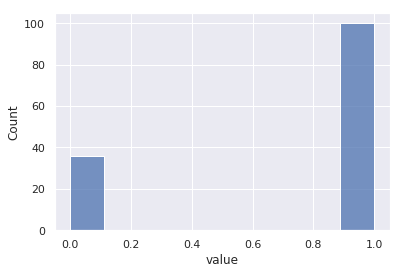





Metric = insightsclient_request_send_total


,__name__,_id,client,container,job,namespace,pod,service,status_code,timestamp,value
0,insightsclient_request_send_total,0077bb81-a9a9-4d71-9d07-e9a38f878a01,default,insights-operator,metrics,openshift-insights,insights-operator-7675c74785-pbhkx,metrics,202,1617105600,8
1,insightsclient_request_send_total,00b9c122-4ea2-4f4d-9d50-18bd73265905,default,insights-operator,metrics,openshift-insights,insights-operator-66dd4bd8c9-pvcgk,metrics,202,1617105600,2
2,insightsclient_request_send_total,047d5398-e885-43d5-92a7-0dd674e078a2,default,insights-operator,metrics,openshift-insights,insights-operator-69486b894d-wvmmw,metrics,202,1617105600,1
3,insightsclient_request_send_total,0a64bbdb-6b90-4208-aff5-dec096216f10,default,insights-operator,metrics,openshift-insights,insights-operator-646694b8dd-q9wzd,metrics,202,1617105600,2
4,insightsclient_request_send_total,0c476eff-fd51-4759-9128-63c946a83c97,default,insights-operator,metrics,openshift-insights,insights-operator-c666564bf-r57lq,metrics,202,1617105600,3


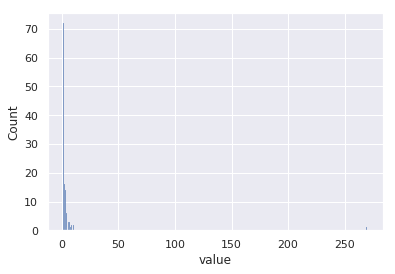





Metric = instance:etcd_object_counts:sum


,__name__,_id,timestamp,value
0,instance:etcd_object_counts:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,9513
1,instance:etcd_object_counts:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,9498
2,instance:etcd_object_counts:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,9352
3,instance:etcd_object_counts:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,482
4,instance:etcd_object_counts:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,482


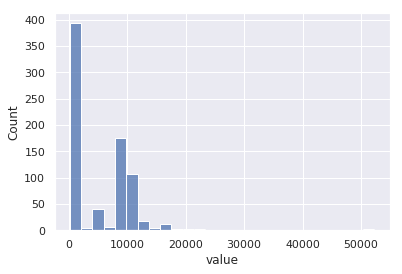





Metric = monitoring:container_memory_working_set_bytes:sum


,__name__,_id,namespace,timestamp,value
0,monitoring:container_memory_working_set_bytes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,openshift-monitoring,1617105600,5038780416
1,monitoring:container_memory_working_set_bytes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,openshift-monitoring,1617105600,6879895552
2,monitoring:container_memory_working_set_bytes:sum,047d5398-e885-43d5-92a7-0dd674e078a2,openshift-monitoring,1617105600,4683087872
3,monitoring:container_memory_working_set_bytes:sum,0a64bbdb-6b90-4208-aff5-dec096216f10,openshift-monitoring,1617105600,4643786752
4,monitoring:container_memory_working_set_bytes:sum,0c476eff-fd51-4759-9128-63c946a83c97,openshift-monitoring,1617105600,5478518784


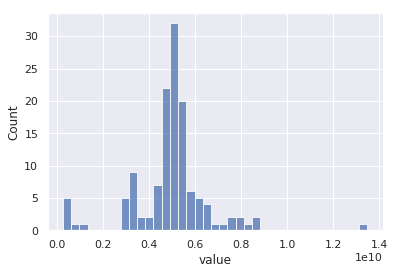





Metric = monitoring:haproxy_server_http_responses_total:sum


,__name__,_id,exported_service,timestamp,value
0,monitoring:haproxy_server_http_responses_total...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,alertmanager-main,1617105600,0
1,monitoring:haproxy_server_http_responses_total...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,grafana,1617105600,0
2,monitoring:haproxy_server_http_responses_total...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,prometheus-k8s,1617105600,0
3,monitoring:haproxy_server_http_responses_total...,00b9c122-4ea2-4f4d-9d50-18bd73265905,alertmanager-main,1617105600,0
4,monitoring:haproxy_server_http_responses_total...,00b9c122-4ea2-4f4d-9d50-18bd73265905,grafana,1617105600,0


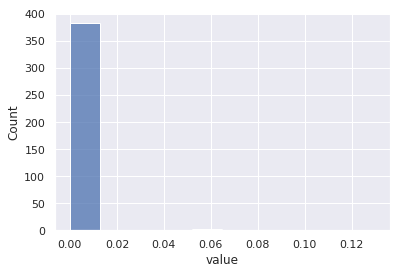





Metric = node_role_os_version_machine:cpu_capacity_cores:sum


,__name__,_id,label_kubernetes_io_arch,label_node_hyperthread_enabled,label_node_openshift_io_os_id,label_node_role_kubernetes_io_master,timestamp,value
0,node_role_os_version_machine:cpu_capacity_core...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,amd64,true,rhcos,true,1617105600,6
1,node_role_os_version_machine:cpu_capacity_core...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,amd64,true,rhcos,NaN,1617105600,6
2,node_role_os_version_machine:cpu_capacity_core...,00b9c122-4ea2-4f4d-9d50-18bd73265905,amd64,true,rhcos,true,1617105600,6
3,node_role_os_version_machine:cpu_capacity_core...,00b9c122-4ea2-4f4d-9d50-18bd73265905,amd64,true,rhcos,NaN,1617105600,6
4,node_role_os_version_machine:cpu_capacity_core...,047d5398-e885-43d5-92a7-0dd674e078a2,amd64,true,rhcos,true,1617105600,6


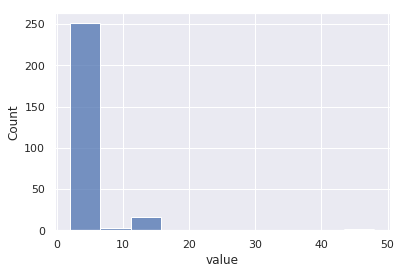





Metric = node_role_os_version_machine:cpu_capacity_sockets:sum


,__name__,_id,label_kubernetes_io_arch,label_node_hyperthread_enabled,label_node_openshift_io_os_id,label_node_role_kubernetes_io_master,timestamp,value
0,node_role_os_version_machine:cpu_capacity_sock...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,amd64,true,rhcos,true,1617105600,3
1,node_role_os_version_machine:cpu_capacity_sock...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,amd64,true,rhcos,NaN,1617105600,3
2,node_role_os_version_machine:cpu_capacity_sock...,00b9c122-4ea2-4f4d-9d50-18bd73265905,amd64,true,rhcos,true,1617105600,3
3,node_role_os_version_machine:cpu_capacity_sock...,00b9c122-4ea2-4f4d-9d50-18bd73265905,amd64,true,rhcos,NaN,1617105600,3
4,node_role_os_version_machine:cpu_capacity_sock...,047d5398-e885-43d5-92a7-0dd674e078a2,amd64,true,rhcos,true,1617105600,3


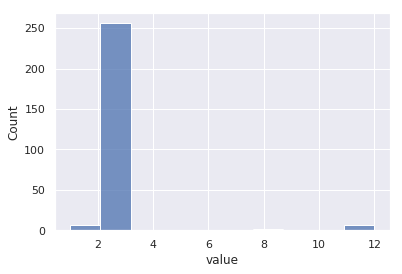





Metric = olm_resolution_duration_seconds


,__name__,_id,container,job,namespace,outcome,pod,quantile,service,timestamp,value
0,olm_resolution_duration_seconds,166885f6-76c6-42c8-8f05-ce1c67986bcf,catalog-operator,catalog-operator-metrics,openshift-operator-lifecycle-manager,succeeded,catalog-operator-56cb997c65-l2gjr,0.9,catalog-operator-metrics,1617105600,2.994864101
1,olm_resolution_duration_seconds,166885f6-76c6-42c8-8f05-ce1c67986bcf,catalog-operator,catalog-operator-metrics,openshift-operator-lifecycle-manager,succeeded,catalog-operator-56cb997c65-l2gjr,0.95,catalog-operator-metrics,1617105600,2.994864101
2,olm_resolution_duration_seconds,166885f6-76c6-42c8-8f05-ce1c67986bcf,catalog-operator,catalog-operator-metrics,openshift-operator-lifecycle-manager,succeeded,catalog-operator-56cb997c65-l2gjr,0.99,catalog-operator-metrics,1617105600,2.994864101
3,olm_resolution_duration_seconds,1a02b3fd-5460-4324-89de-4e44ed19a8c7,catalog-operator,catalog-operator-metrics,openshift-operator-lifecycle-manager,succeeded,catalog-operator-5944f8f4b7-dwcpq,0.9,catalog-operator-metrics,1617105600,1.887512449
4,olm_resolution_duration_seconds,1a02b3fd-5460-4324-89de-4e44ed19a8c7,catalog-operator,catalog-operator-metrics,openshift-operator-lifecycle-manager,succeeded,catalog-operator-5944f8f4b7-dwcpq,0.95,catalog-operator-metrics,1617105600,1.887512449


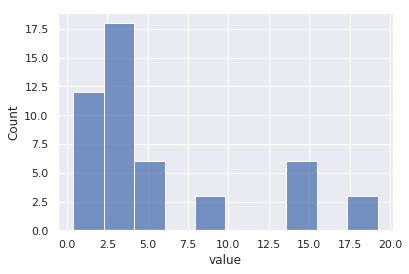





Metric = openshift:cpu_usage_cores:sum


,__name__,_id,timestamp,value
0,openshift:cpu_usage_cores:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,3.5234482022978866
1,openshift:cpu_usage_cores:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,3.6671295000432886
2,openshift:cpu_usage_cores:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,3.576838371769494
3,openshift:cpu_usage_cores:sum,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,2.5040696843516734
4,openshift:cpu_usage_cores:sum,1433564d-58c8-48a4-a723-390be248ef10,1617105600,3.800585735558715


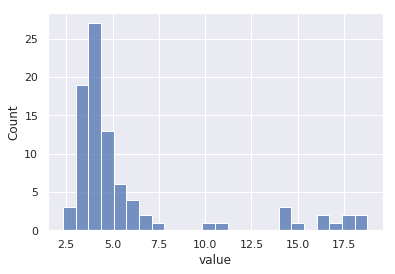





Metric = openshift:memory_usage_bytes:sum


,__name__,_id,timestamp,value
0,openshift:memory_usage_bytes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,30233038848
1,openshift:memory_usage_bytes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,27376762880
2,openshift:memory_usage_bytes:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,29539934208
3,openshift:memory_usage_bytes:sum,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,29289820160
4,openshift:memory_usage_bytes:sum,1433564d-58c8-48a4-a723-390be248ef10,1617105600,30102913024


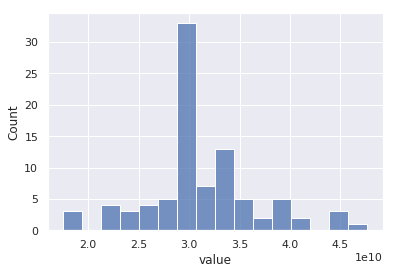





Metric = openshift:prometheus_tsdb_head_samples_appended_total:sum


,__name__,_id,job,namespace,timestamp,value
0,openshift:prometheus_tsdb_head_samples_appende...,0077bb81-a9a9-4d71-9d07-e9a38f878a01,prometheus-k8s,openshift-monitoring,1617105600,14171.471056588958
1,openshift:prometheus_tsdb_head_samples_appende...,00b9c122-4ea2-4f4d-9d50-18bd73265905,prometheus-k8s,openshift-monitoring,1617105600,14070.355555555556
2,openshift:prometheus_tsdb_head_samples_appende...,047d5398-e885-43d5-92a7-0dd674e078a2,prometheus-k8s,openshift-monitoring,1617105600,14363.855555555554
3,openshift:prometheus_tsdb_head_samples_appende...,0a64bbdb-6b90-4208-aff5-dec096216f10,prometheus-k8s,openshift-monitoring,1617105600,14536.255555555555
4,openshift:prometheus_tsdb_head_samples_appende...,0c476eff-fd51-4759-9128-63c946a83c97,prometheus-k8s,openshift-monitoring,1617105600,15628.255555555555


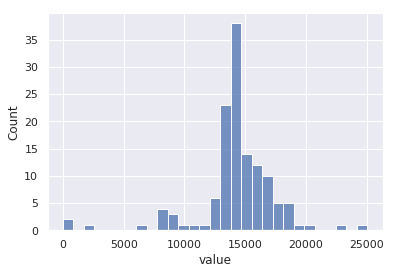





Metric = openshift:prometheus_tsdb_head_series:sum


,__name__,_id,job,namespace,timestamp,value
0,openshift:prometheus_tsdb_head_series:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,prometheus-k8s,openshift-monitoring,1617105600,518684
1,openshift:prometheus_tsdb_head_series:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,prometheus-k8s,openshift-monitoring,1617105600,1213575
2,openshift:prometheus_tsdb_head_series:sum,047d5398-e885-43d5-92a7-0dd674e078a2,prometheus-k8s,openshift-monitoring,1617105600,491339
3,openshift:prometheus_tsdb_head_series:sum,0a64bbdb-6b90-4208-aff5-dec096216f10,prometheus-k8s,openshift-monitoring,1617105600,512326
4,openshift:prometheus_tsdb_head_series:sum,0c476eff-fd51-4759-9128-63c946a83c97,prometheus-k8s,openshift-monitoring,1617105600,687707


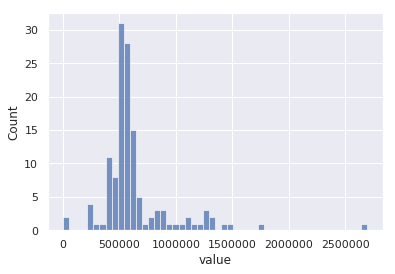





Metric = workload:cpu_usage_cores:sum


,__name__,_id,timestamp,value
0,workload:cpu_usage_cores:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,0.004075607225925927
1,workload:cpu_usage_cores:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,0.053210683140411
2,workload:cpu_usage_cores:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,0.6016871521053444
3,workload:cpu_usage_cores:sum,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,0.5535493632673739
4,workload:cpu_usage_cores:sum,1433564d-58c8-48a4-a723-390be248ef10,1617105600,0.05246188348888888


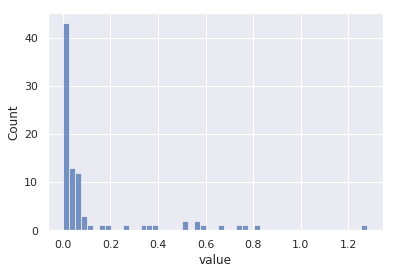





Metric = workload:memory_usage_bytes:sum


,__name__,_id,timestamp,value
0,workload:memory_usage_bytes:sum,0077bb81-a9a9-4d71-9d07-e9a38f878a01,1617105600,102727680
1,workload:memory_usage_bytes:sum,00b9c122-4ea2-4f4d-9d50-18bd73265905,1617105600,567308288
2,workload:memory_usage_bytes:sum,047d5398-e885-43d5-92a7-0dd674e078a2,1617105600,2006016000
3,workload:memory_usage_bytes:sum,0db5aad5-7099-4fa5-8dd1-086a6499af5a,1617105600,1918685184
4,workload:memory_usage_bytes:sum,1433564d-58c8-48a4-a723-390be248ef10,1617105600,408944640


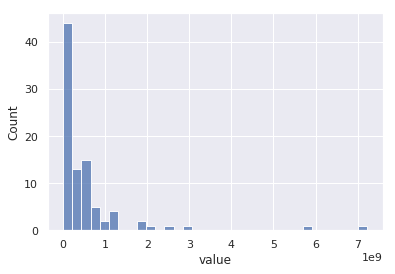

In [15]:
# ids of the deployments we're interested in.
cicd_cluster_ids = cicd_invokers["_id"].unique()

# query filter for ids.
id_filter = "|".join(_id for _id in cicd_cluster_ids)

# display data for each metric.
all_metrics_df = pd.DataFrame()
for metric in metrics_to_fetch:

    # fetch the metric
    metric_df = MetricSnapshotDataFrame(
        pc.custom_query(
            query=f'{metric}{{_id=~"{id_filter}"}}',
            params={"time": query_eval_ts},
        )
    )

    if len(metric_df) > 0:
        # drop irrelevant cols, if any
        metric_df.drop(columns=drop_cols, errors="ignore", inplace=True)

        # show a glimpse of data
        print(f"Metric = {metric}")
        display(metric_df.head())

        # visualize distribution of values
        sns.histplot(
            metric_df["value"].astype(float),
        )
        plt.show()
        print("\n\n\n")

        # combine all the metrics data.
        all_metrics_df = pd.concat(
            [
                all_metrics_df,
                metric_df,
            ],
            axis=0,
            join="outer",
            ignore_index=True,
        )

In [16]:
# save the metrics as a static dataset to use in future
all_metrics_df.to_parquet(f"../../../data/raw/telemetry_data_{query_eval_ts}.parquet")

## Conclusion

In this notebook, we have :
- Collected all telemetry data corresponding to a given job and build.
- Understood how to interpret Prometheus data using an example metric.
- Collected all telemetry data for all the clusters running CI jobs.
- Visualized what the general distribution of values looks like.
- Saved the above data for further analysis.